In [1]:
# import tsfresh

In [1]:
import numpy as np
import shap
n_features = 'all'
# data_file_name = 'data_for_training_tsfeatures_models'
data_file_name = 'data_for_y15_models'

endpt = 17
eval_times = np.r_[np.arange(1, endpt+1, 1)]
training_id_file_name = 'all_training_set_ID_2'
validation_id_file_name = 'all_validation_set_ID_2'
testing_id_file_name = 'all_testing_set_ID_2'
#work_dir = '/home/idies/workspace/Storage/hnguye78/persistent/CARDIA_longi_project/'
work_dir = 'U:/Hieu/CARDIA_longi_project/'

In [2]:
# %pip install plotly
# %pip install tensorflow
# %pip install lifelines

#!y | pip uninstall statsmodels 
# %pip install statsmodels==0.11.0

# %pip install keras

In [3]:
import pkg_resources
#pkg_resources.require("scikit-learn==1.0.2")
import sklearn

import sksurv

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from numpy.random import seed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [4]:
load_dir = work_dir+ '/csv_files'

# load data:
data_full = pd.read_csv(load_dir+'/'+data_file_name+'.csv')
data_full = data_full.select_dtypes(include =[np.number])



In [5]:
# load training id:
loaddir = work_dir+ '/csv_files'
trainingid_all = pd.read_csv(loaddir+'/'+training_id_file_name+'.csv')
validationid_all = pd.read_csv(loaddir+'/'+validation_id_file_name+'.csv')
testingid_all = pd.read_csv(loaddir+'/'+testing_id_file_name+'.csv')


## no need to standardize feature space since RSF can handle it, then merge back to label space:
feature_space = data_full.drop(['ID','event','time'], axis = 1)
feature_name_list = feature_space.columns.values


In [6]:
data_full

ID  event       time  MALE  RACEBLACK  ARMCI  ASMA  BEER  \
0     100033323702      0  17.134155     1          0   35.0     0     0   
1     100056526386      0  17.142368     1          1   36.0     0     1   
2     100061300991      0  17.427105     1          1   35.0     0     8   
3     100080112533      0  17.057495     1          1   33.0     0     0   
4     100101126081      0  17.424367     0          1   50.0     0     0   
...            ...    ...        ...   ...        ...    ...   ...   ...   
3534  416752023336      0  16.704312     1          1   33.0     0     0   
3535  416761219907      0  16.674196     0          0   29.0     0     0   
3536  416783315386      0  16.690623     0          0   25.5     0     0   
3537  416796224310      0  16.761807     0          1   41.5     1     0   
3538  416817227898      0  16.770021     1          1   37.5     0    16   

            BMI  CANCR  ...  SMKNW    WGT  WINE    WST  HBM  DBP  SBP  CHNOW  \
0     25.680330      0  ...      0  178.0     0   82.5    0   71  107      0   
1     30.218171      0  ...      0  219.0     2   99.0    0  101  155      0   
2     30.062319      0  ...      1  235.0     0   97.0    0   85  159      0   
3     22.747420      0  ...      0  175.0     0   84.5    0   72  113      0   
4     39.548526      0  ...      0  248.5     0  101.0    0   67  102      0   
...         ...    ...  ...    ...    ...   ...    ...  ...  ...  ...    ...   
3534  26.210050      0  ...      0  191.0     0   96.5    0   79  117      0   
3535  25.692550      0  ...      0  142.0     0   77.0    0   79  123      0   
3536  20.409280      0  ...      0  129.0     0   71.0    0   66  104      0   
3537  40.326230      0  ...      0  243.0     2  106.0    0   55   99      0   
3538  28.885950      0  ...      1  210.5     0  102.5    0   70  106      0   

      PATCK  AGE_Y15  
0         0       37  
1         0       43  
2         0       35  
3         0       35  
4         0       43  
...     ...      ...  
3534      0       41  
3535      1       45  
3536      0       42  
3537      1       42  
3538      0       37  

[3539 rows x 38 columns]

In [7]:
def f_rsf_input_as_matrix(X):
    surv = rsf.predict_survival_function(X, return_array=True)
    last_yr_pred_prob_surv=surv[:,-1]
    return last_yr_pred_prob_surv


def vimp_shap_tabular(feature_names, vals):
    feature_importance_df = pd.DataFrame(list(zip(feature_names, vals)), columns=['variable_name','vimp'])
    feature_importance_df.sort_values(by=['vimp'], ascending=False,inplace=True)
    feature_importance_df['normalized_vimp'] = (feature_importance_df['vimp'] - min(feature_importance_df['vimp']))/(max(feature_importance_df['vimp'])-min(feature_importance_df['vimp']))
    
   # merge with variable description:
   # var_dict = pd.read_csv(load_dir+'/y5_all_vars_dictionary_manually_selecting_vars (3).csv', encoding= 'unicode_escape')
   # var_dict[['Variable.Name', 'Variable.Label']]
    ## merge vimp table with var dict to get var description:
    # feature_importance_df_with_vardes = feature_importance_df.merge(
    #    var_dict[['Variable.Name', 'Variable.Label']], how = 'inner', right_on= 'Variable.Name', left_on = 'variable_name', copy= False)
    return(feature_importance_df[['variable_name','normalized_vimp','vimp']])


In [8]:
# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)



FOLD 0:



In [9]:
featurespace_train_df

MALE  RACEBLACK  ARMCI  ASMA  BEER        BMI  CANCR  CGTDY  CHOL  \
0        1          0   35.0     0     0  25.680330      0      0   214   
2        1          1   35.0     0     8  30.062319      0      8   202   
6        0          1   43.0     0     0  47.283535      0      0   151   
8        0          1   31.0     0     0  27.715143      0      0   175   
9        0          0   27.0     0     0  23.167743      0      0   209   
...    ...        ...    ...   ...   ...        ...    ...    ...   ...   
3533     1          1   33.0     0    10  26.405970      0      0   185   
3535     0          0   29.0     0     0  25.692550      0      0   254   
3536     0          0   25.5     0     0  20.409280      0      0   130   
3537     0          1   41.5     1     0  40.326230      0      0   150   
3538     1          1   37.5     0    16  28.885950      0     15   223   

      DFPAY  ...  SMKNW    WGT  WINE    WST  HBM  DBP  SBP  CHNOW  PATCK  \
0         4  ...      0  178.0     0   82.5    0   71  107      0      0   
2         3  ...      1  235.0     0   97.0    0   85  159      0      0   
6         4  ...      0  273.0     0  114.0    1   71  110      0      0   
8         3  ...      0  162.0     0   85.5    0   80  111      0      0   
9         4  ...      0  143.0     0   79.0    0   65   88      0      0   
...     ...  ...    ...    ...   ...    ...  ...  ...  ...    ...    ...   
3533      4  ...      0  182.0     0   87.0    0   77  111      0      0   
3535      4  ...      0  142.0     0   77.0    0   79  123      0      1   
3536      4  ...      0  129.0     0   71.0    0   66  104      0      0   
3537      4  ...      0  243.0     2  106.0    0   55   99      0      1   
3538      2  ...      1  210.5     0  102.5    0   70  106      0      0   

      AGE_Y15  
0          37  
2          35  
6          34  
8          38  
9          42  
...       ...  
3533       42  
3535       45  
3536       42  
3537       42  
3538       37  

[2828 rows x 35 columns]

In [10]:
featurespace_test_df

MALE  RACEBLACK  ARMCI  ASMA  BEER        BMI  CANCR  CGTDY  CHOL  \
1        1          1   36.0     0     1  30.218171      0      0   160   
3        1          1   33.0     0     0  22.747420      0      0   161   
4        0          1   50.0     0     0  39.548526      0      0   135   
5        1          1   39.0     0     0  33.027582      0      0   206   
7        0          0   27.0     0     0  22.466026      0      0   160   
...    ...        ...    ...   ...   ...        ...    ...    ...   ...   
3508     0          0   23.6     0     0  20.454460      0      0   161   
3510     0          1   31.0     0     0  27.276500      0     20   104   
3514     0          1   32.5     0     0  33.472680      0      0   199   
3519     0          0   27.4     0     0  23.062200      0      0   122   
3534     1          1   33.0     0     0  26.210050      0      0   222   

      DFPAY  ...  SMKNW    WGT  WINE    WST  HBM  DBP  SBP  CHNOW  PATCK  \
1         4  ...      0  219.0     2   99.0    0  101  155      0      0   
3         4  ...      0  175.0     0   84.5    0   72  113      0      0   
4         4  ...      0  248.5     0  101.0    0   67  102      0      0   
5         4  ...      0  246.0     0  107.0    1  128  159      0      0   
7         3  ...      0  142.0     0   66.0    0   61   99      0      1   
...     ...  ...    ...    ...   ...    ...  ...  ...  ...    ...    ...   
3508      4  ...      0  125.5     0   70.0    0   49   89      0      0   
3510      4  ...      1  188.0     0   92.0    0   76  134      0      1   
3514      4  ...      0  185.0     1   89.5    0   71  108      0      0   
3519      4  ...      0  141.5     4   71.0    0   52   92      0      0   
3534      4  ...      0  191.0     0   96.5    0   79  117      0      0   

      AGE_Y15  
1          43  
3          35  
4          43  
5          34  
7          45  
...       ...  
3508       39  
3510       44  
3514       42  
3519       43  
3534       41  

[711 rows x 35 columns]

In [11]:

##########################
# Build model:


seed(1)
rsf = RandomSurvivalForest(n_estimators=101,
                       min_samples_split=10,
                       min_samples_leaf=15,
                       max_features="sqrt",
                       n_jobs=-1,
                       random_state=20)
rsf.fit(featurespace_train_df, y_train) 

rsf.score(featurespace_test_df, y_test) 
# c_index[fold] = rsf.score(featurespace_test_df, y_test) 



0.7740283457064592

In [12]:
savedir = os.path.join(work_dir,'csv_files/rsf_y15_SHAP/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1


## SHAP:

seed(1)
X_train_df_summary = shap.kmeans(featurespace_train_df, 7) #10

seed(1)
explainer_kmeans = shap.KernelExplainer(f_rsf_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
kmeans_shaps = explainer_kmeans.shap_values(featurespace_test_df)



In [13]:
vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(kmeans_shaps).mean(0))

vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_expanded_var_fold_'+str(actual_fold)+'.csv', index = None, header = True)


In [16]:
pd.DataFrame(kmeans_shaps).to_csv(savedir+'/all_kmeans_shap_values_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [15]:
kmeans_shaps_df = pd.DataFrame(kmeans_shaps)
kmeans_shaps_df.columns = featurespace_test_df.columns
pd.DataFrame(kmeans_shaps_df).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

In [17]:
explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_2_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(explainer_kmeans.expected_value))


## Load saved shap values:

In [18]:
old_loadir = 'U:/Hieu/CARDIA_longi_project/csv_files/rsf_y15_SHAP/all_features'
old_kmeans_shaps = pd.read_csv(old_loadir+'/all_kmeans_shap_values_df_expanded_var_2_fold_1.csv')

In [19]:
old_kmeans_shaps

MALE  RACEBLACK     ARMCI  ASMA      BEER       BMI  CANCR     CGTDY  \
0   -0.002507  -0.002649 -0.002776   0.0  0.000000  0.000000    0.0  0.007869   
1   -0.001823  -0.001597 -0.001577   0.0 -0.001569  0.000000    0.0  0.005560   
2    0.000000  -0.001336 -0.015673   0.0  0.002784 -0.004613    0.0  0.003381   
3   -0.003613   0.000000 -0.005692   0.0 -0.004306 -0.008196    0.0  0.000000   
4    0.000769   0.000364  0.000000   0.0  0.000000  0.001249    0.0  0.005137   
..        ...        ...       ...   ...       ...       ...    ...       ...   
706  0.000804   0.000402  0.000000   0.0  0.000000  0.000437    0.0  0.001807   
707  0.000000  -0.002739  0.000000   0.0 -0.001082 -0.001421    0.0 -0.013198   
708  0.000904  -0.000750  0.000669   0.0  0.000000 -0.002536    0.0  0.004912   
709  0.000000   0.000000 -0.001190   0.0 -0.000576  0.000543    0.0  0.003179   
710 -0.002431  -0.001540 -0.004941   0.0  0.000461  0.001889    0.0  0.013179   

         CHOL     DFPAY  ...     SMKNW       WGT      WINE       WST      HBM  \
0    0.006426  0.000000  ...  0.000000  0.000000  0.000000 -0.007133  0.00000   
1    0.003223  0.000000  ...  0.000000 -0.001612 -0.001070  0.008287  0.00000   
2   -0.002444  0.000000  ...  0.000000 -0.001694 -0.000417 -0.007858  0.00000   
3    0.000000  0.000000  ...  0.000000  0.000000  0.000000 -0.005275 -0.04385   
4    0.001647 -0.000701  ...  0.000000  0.003142 -0.001094  0.012176  0.00000   
..        ...       ...  ...       ...       ...       ...       ...      ...   
706  0.001092  0.000000  ...  0.000000  0.002692 -0.000918  0.012937  0.00000   
707  0.000000  0.000000  ... -0.004407 -0.002211  0.000000  0.004312  0.00000   
708  0.001556  0.000000  ...  0.000000  0.000000  0.000000  0.005605  0.00000   
709  0.000000  0.000000  ...  0.000000  0.000513  0.000000  0.011163  0.00000   
710 -0.009898  0.000000  ...  0.000000  0.000966 -0.001006 -0.002505  0.00000   

          DBP       SBP  CHNOW     PATCK   AGE_Y15  
0   -0.043062 -0.094155    0.0  0.000000 -0.003932  
1    0.000678  0.002195    0.0  0.000000  0.001912  
2    0.002201  0.010206    0.0  0.000000 -0.004414  
3   -0.080399 -0.088311    0.0  0.000000 -0.005396  
4    0.000381  0.004526    0.0 -0.003781 -0.006123  
..        ...       ...    ...       ...       ...  
706 -0.002973  0.002734    0.0  0.000000  0.000731  
707  0.000000 -0.020672    0.0 -0.003938 -0.008696  
708  0.001881  0.006326    0.0  0.000000 -0.003057  
709 -0.001826  0.003039    0.0  0.000000 -0.003596  
710  0.000000 -0.004576    0.0  0.000000 -0.002682  

[711 rows x 35 columns]

In [24]:
kmeans_shaps= old_kmeans_shaps.to_numpy()
kmeans_shaps

array([[-0.00072732,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.00040259,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -0.00406199, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.0001118 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

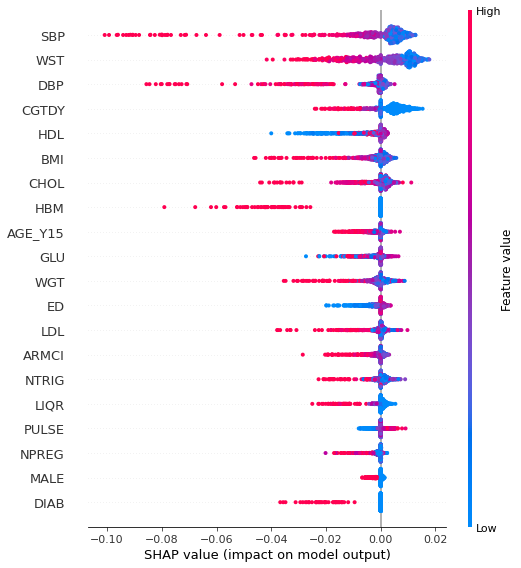

In [20]:
shap.initjs()
shap.summary_plot(old_kmeans_shaps.to_numpy(), featurespace_test_df)


In [ ]:
# import pickle 
# file_explainer_kmeans = open(savedir+'/'+'file_explainer_kmeans.obj', 'wb') 
# pickle.dump(explainer_kmeans, file_explainer_kmeans)



In [ ]:
# import pickle 

# load_kmeans_shaps = pickle.load(open(savedir+'/'+'file_kmeans_shaps.obj', 'r'))

In [21]:
explainer_kmeans.expected_value

0.9736019156658258

In [22]:
shap.initjs()
shap.force_plot(explainer_kmeans.expected_value, kmeans_shaps[0],featurespace_test_df.iloc[0,:])


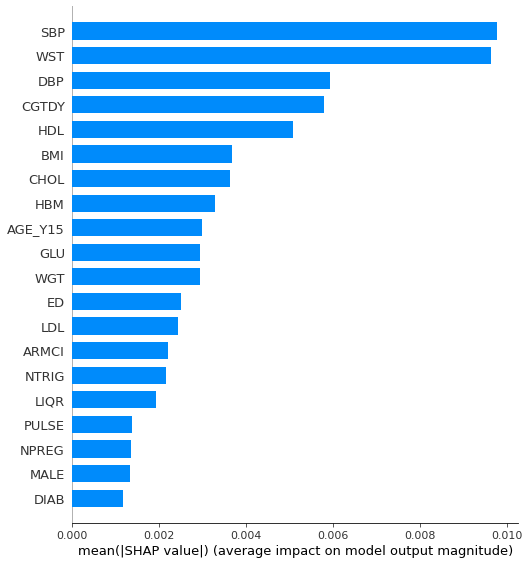

In [23]:
# shap.initjs()

shap.summary_plot(kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


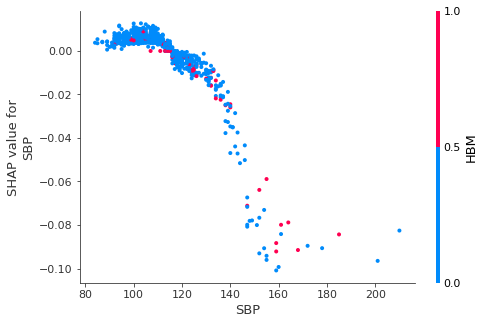

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


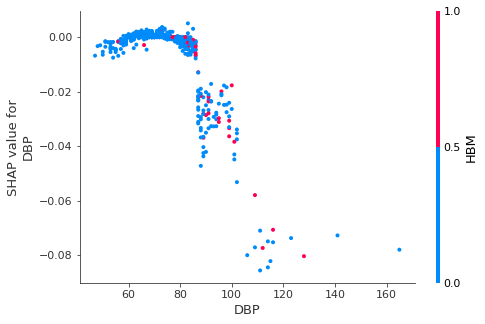

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


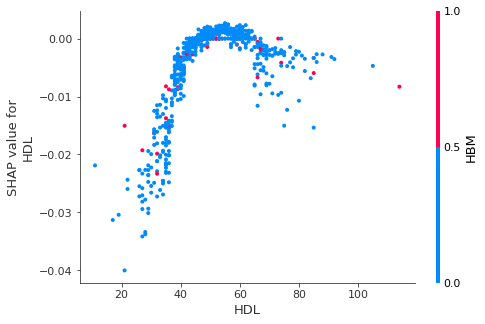

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


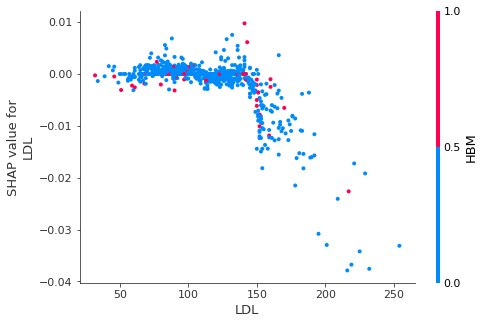

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


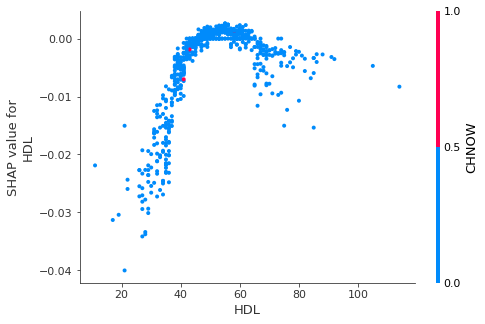

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


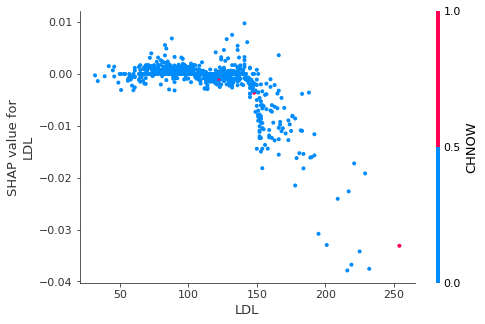

In [24]:
shap.dependence_plot("SBP", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("DBP", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("HDL", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("LDL", kmeans_shaps, featurespace_test_df,interaction_index='HBM')
shap.dependence_plot("HDL", kmeans_shaps, featurespace_test_df,interaction_index='CHNOW')
shap.dependence_plot("LDL", kmeans_shaps, featurespace_test_df,interaction_index='CHNOW')

In [ ]:
# shap.dependence_plot("SBP__standard_deviation", kmeans_shaps, featurespace_test_df,interaction_index=None)


In [ ]:
# # old:
# top_n_var = 20
# top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
# for i in range(top_n_var):
#     var_oi = top_var_names_arr[i]
#     shap.dependence_plot(var_oi, kmeans_shaps, featurespace_test_df,interaction_index=None)



In [ ]:
# import matplotlib.pyplot as plt
# kmeans_shaps[:,idx_glu].shape
# featurespace_test_df.iloc[:, idx_glu].shape
# plt.scatter(featurespace_test_df.iloc[:, idx_glu], kmeans_shaps[:,idx_glu])

In [ ]:
test_df

In [ ]:
df_for_bc.loc[df_for_bc[featurespace_test_df.columns[idx_oi]] > 5000]

In [ ]:
data_full.loc[data_full['ID'].isin(testingid),:].loc[featurespace_test_df['GLU__change_quantiles__f_agg_.var.__isabs_True__qh_1.0__ql_0.6'] > 5000]

In [ ]:

# import plotly.graph_objects as go

# fig_scatter = px.scatter(df_for_bc
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
#                  #hover_name="country"
#                  #, log_x=True,                               
#                  , size_max=10
                
#                 )

# fig = go.Figure(data=[go.Scatter(
#     df_for_bc.to_dict()
#     , x= featurespace_test_df.columns[idx_oi]
#     , y='SHAP value'
#     , size='time'
#     , color='event'
    
#     , mode='markers',
#     marker=dict(
#         color=['rgb(93, 164, 214)', 'rgb(255, 144, 14)',
#                'rgb(44, 160, 101)', 'rgb(255, 65, 54)'],
#         opacity=[1, 0.8, 0.6, 0.4],
#         size=[40, 60, 80, 100],
#     )
# )])

# fig.show()


# fig.show()

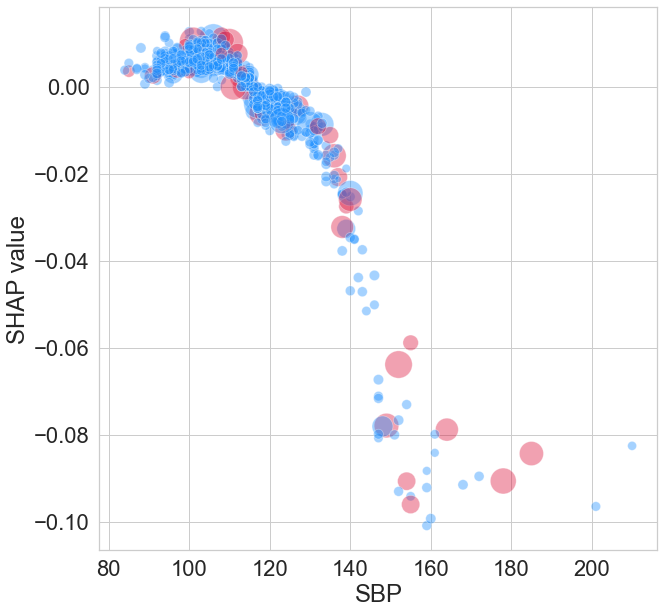

In [25]:
## Bubble Chart:


idx_SBP = featurespace_test_df.columns.get_loc('SBP')


idx_oi = idx_SBP
df_for_bc = pd.DataFrame({featurespace_test_df.columns[idx_oi]:featurespace_test_df.iloc[:, idx_oi]
                         , 'SHAP value': kmeans_shaps[:,idx_oi]
                         , 'event': test_df.event.values
                         , 'time': test_df.time.values})
df_for_bc['Event'] = df_for_bc['event'].astype('category')

# df_for_bc['invert_time'] = swap_relative_values(df_for_bc['time'])
df_for_bc['invert_time'] = -(df_for_bc['time'])
df_for_bc['Time (months)'] = -(df_for_bc['time'])


import seaborn as sns
sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
#sns.set()
#fig, ax = plt.subplots(figsize=(10, 10))

bc_plot = sns.scatterplot(data=df_for_bc
                , x=featurespace_test_df.columns[idx_oi]
                , y='SHAP value'
                , size= 'Time (months)'
                , hue='Event', palette = ['dodgerblue', 'crimson']
                , alpha=0.4, sizes=(40, 800)
                # , ax = ax
                , legend = False
                )
# plt.legend(loc = 'center left', markerscale = 2
#            , bbox_to_anchor = (1, 0.5))

plt.show()



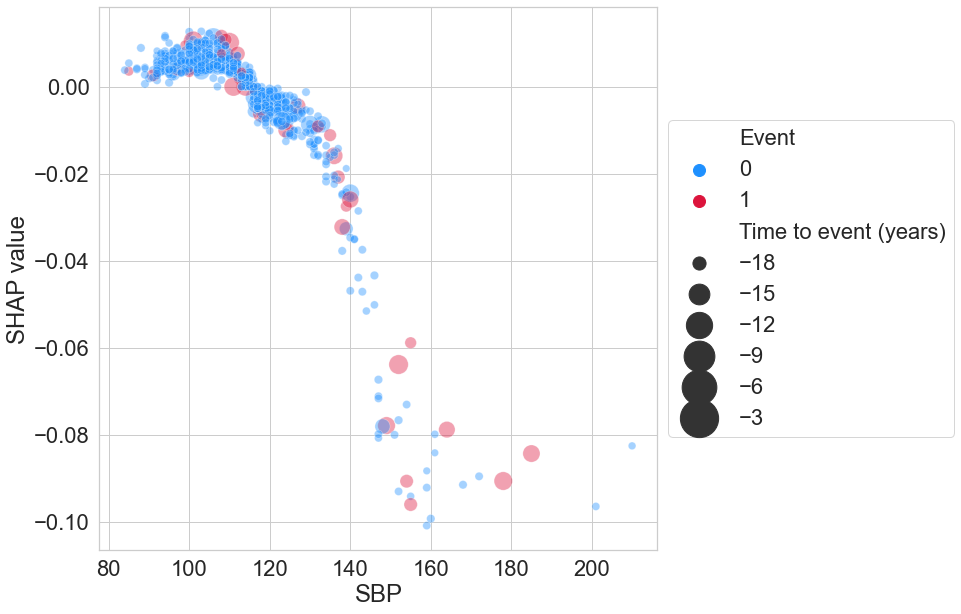

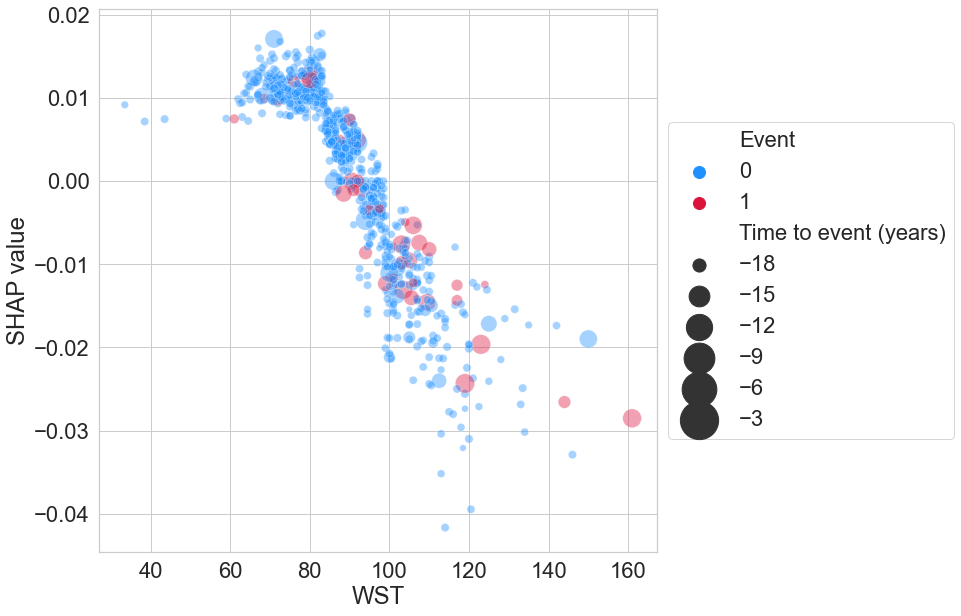

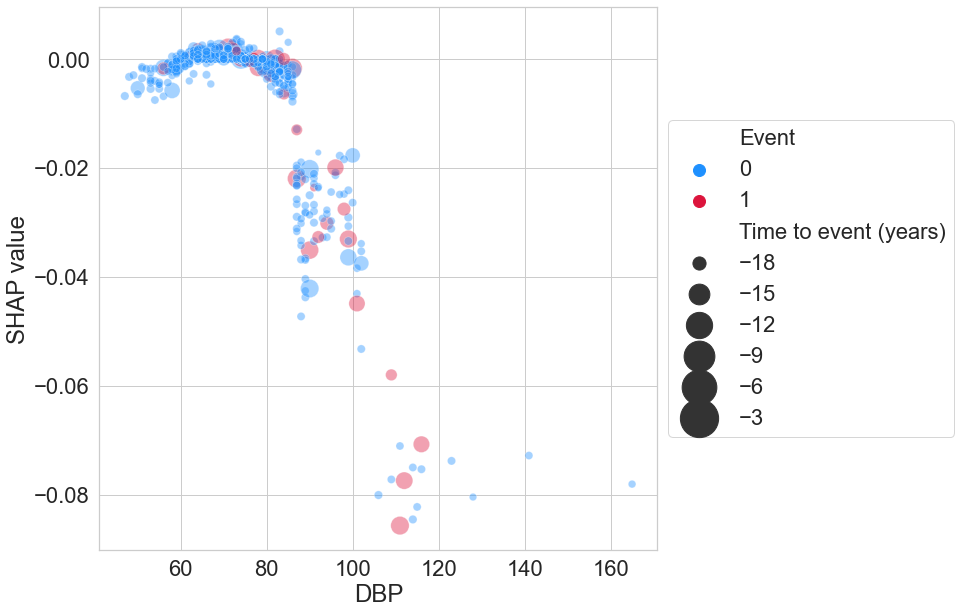

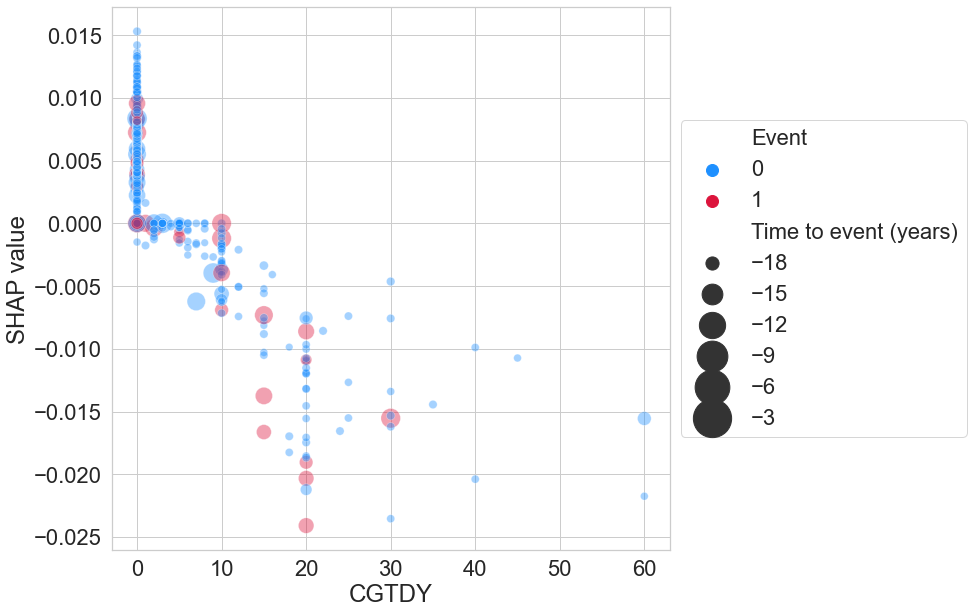

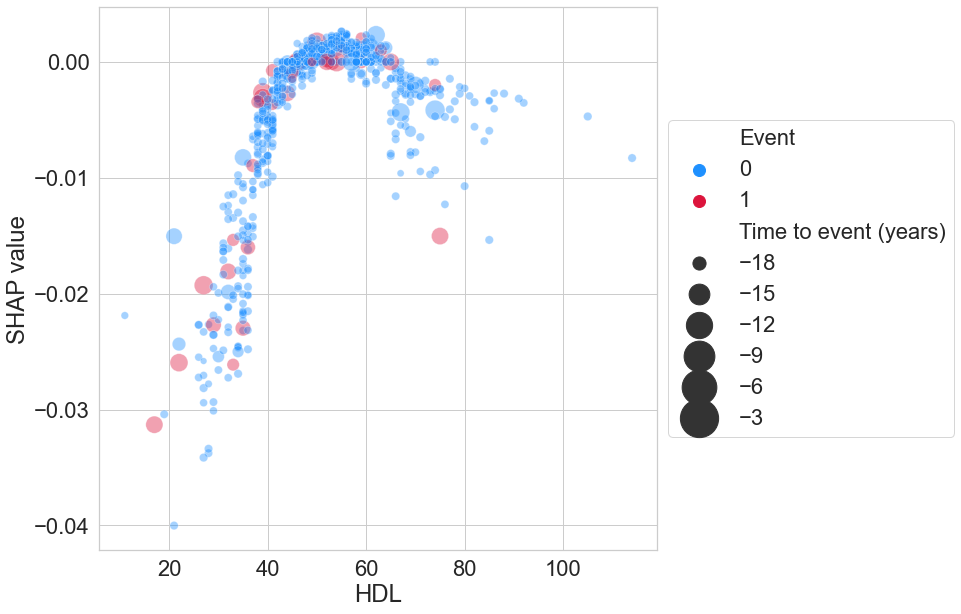

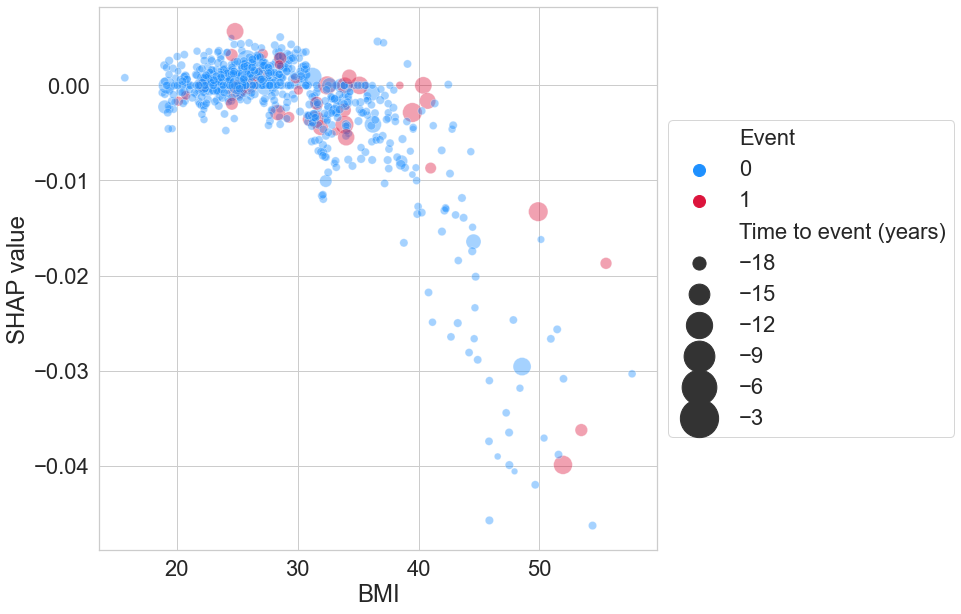

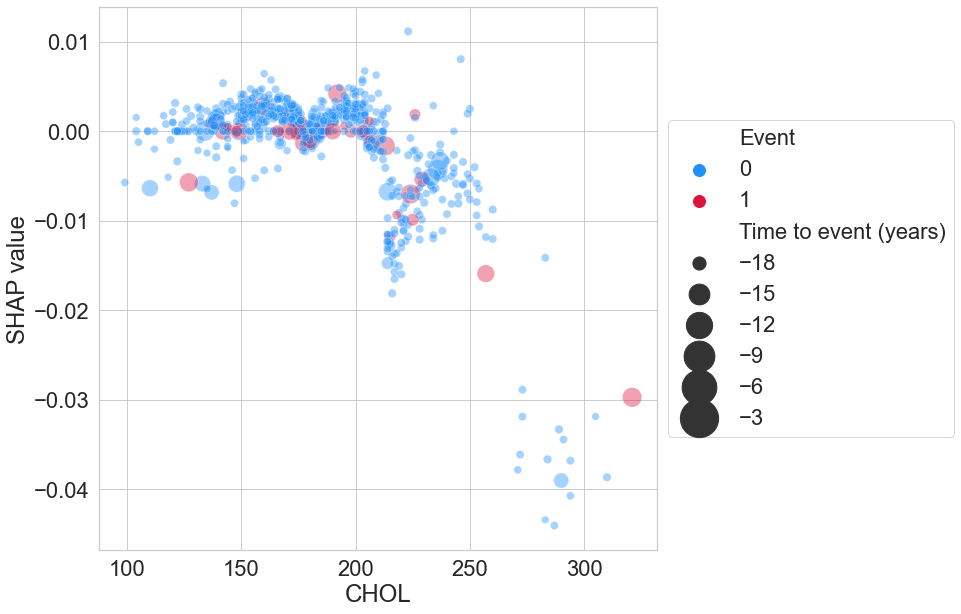

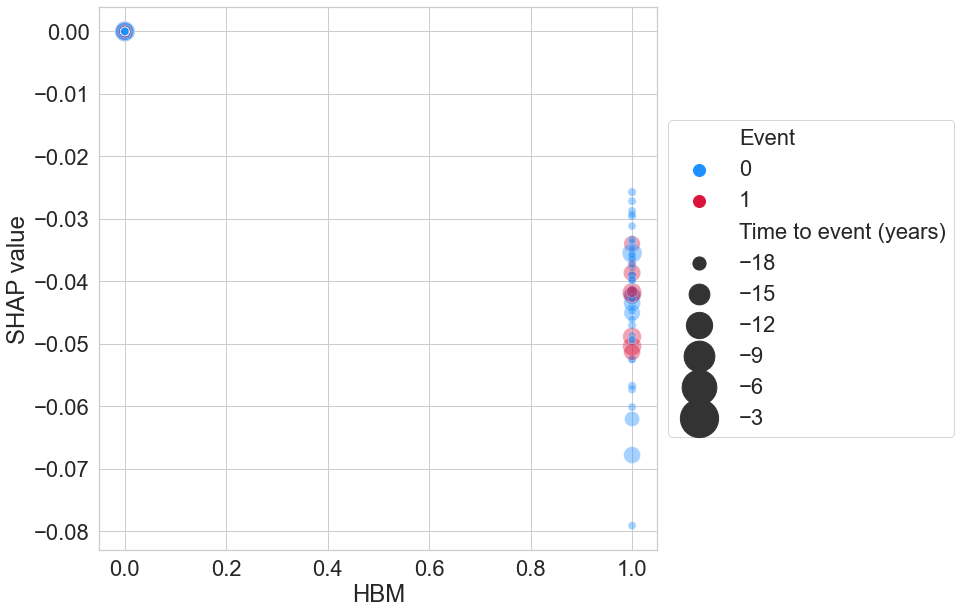

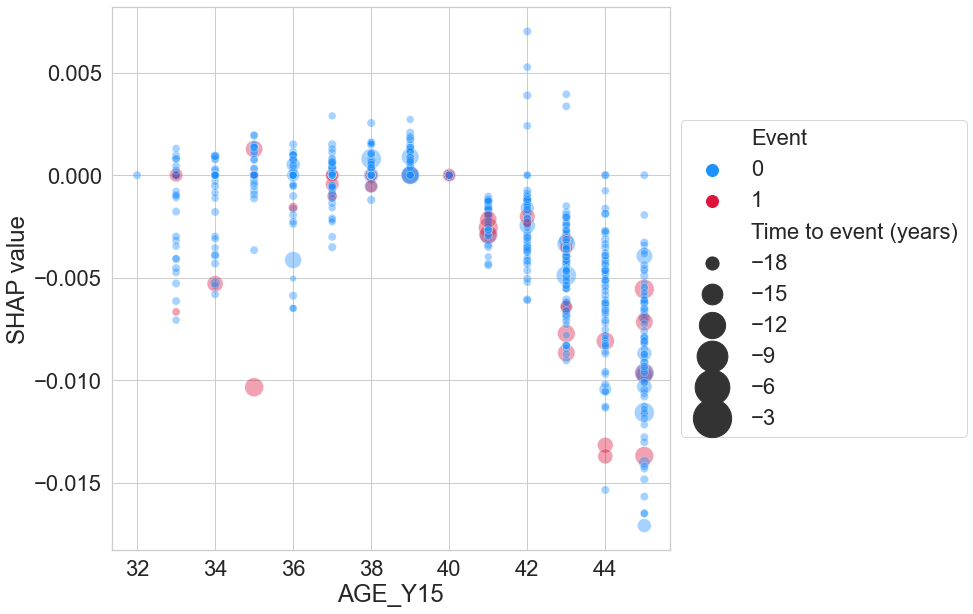

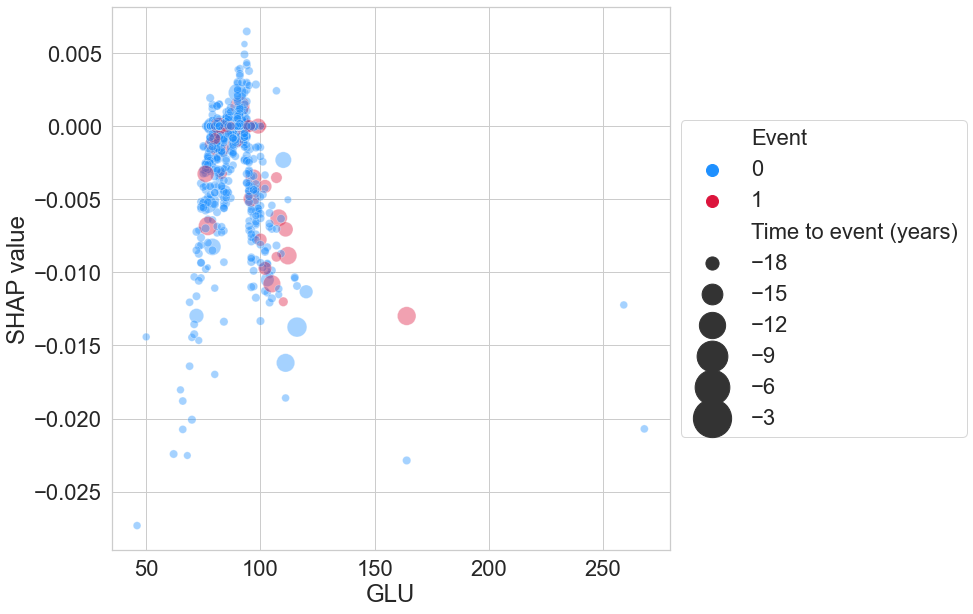

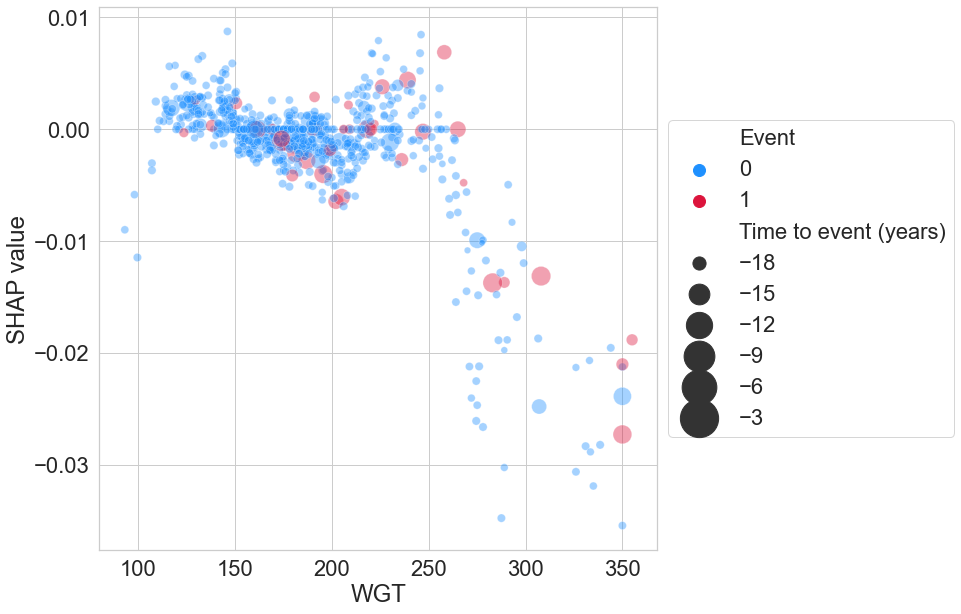

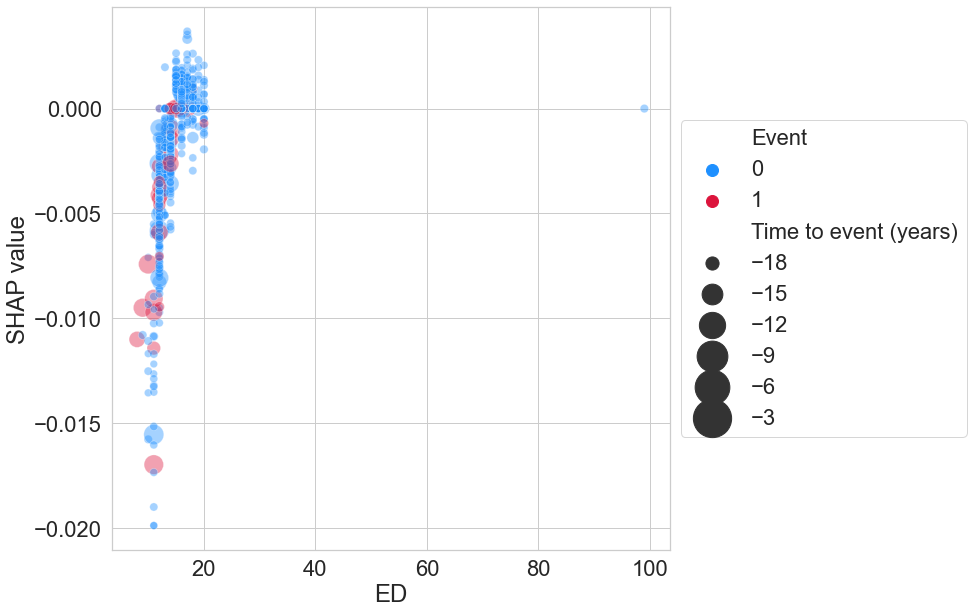

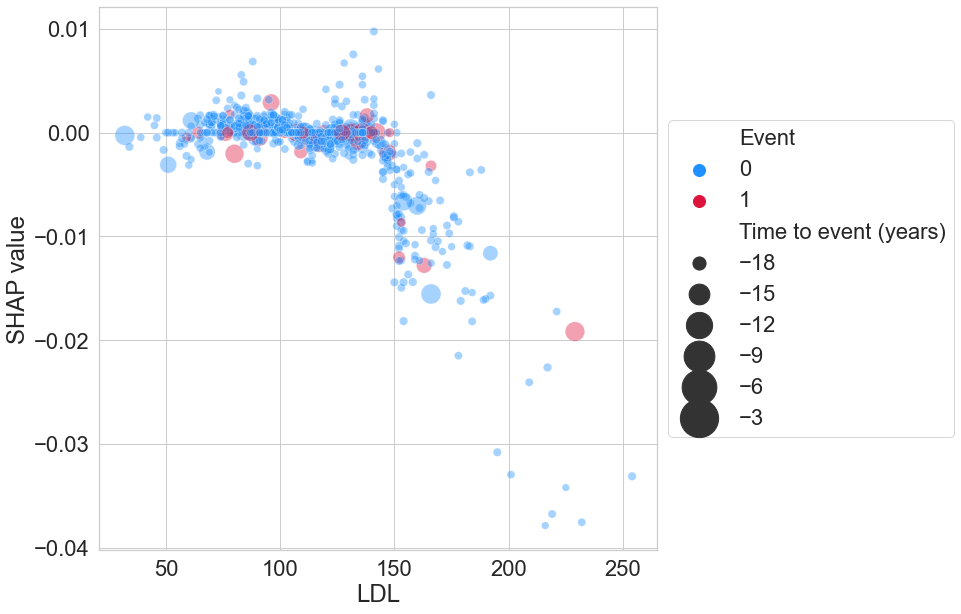

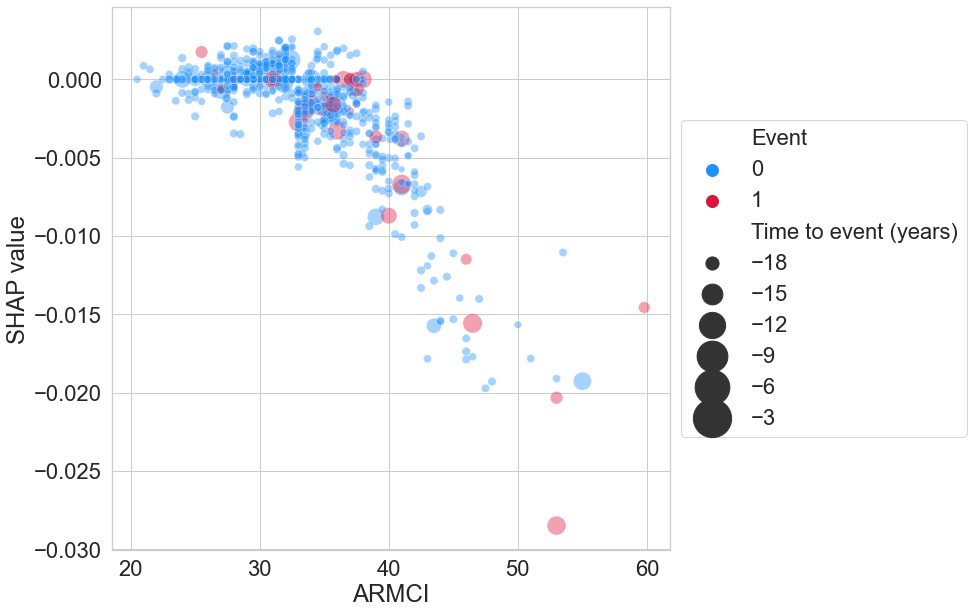

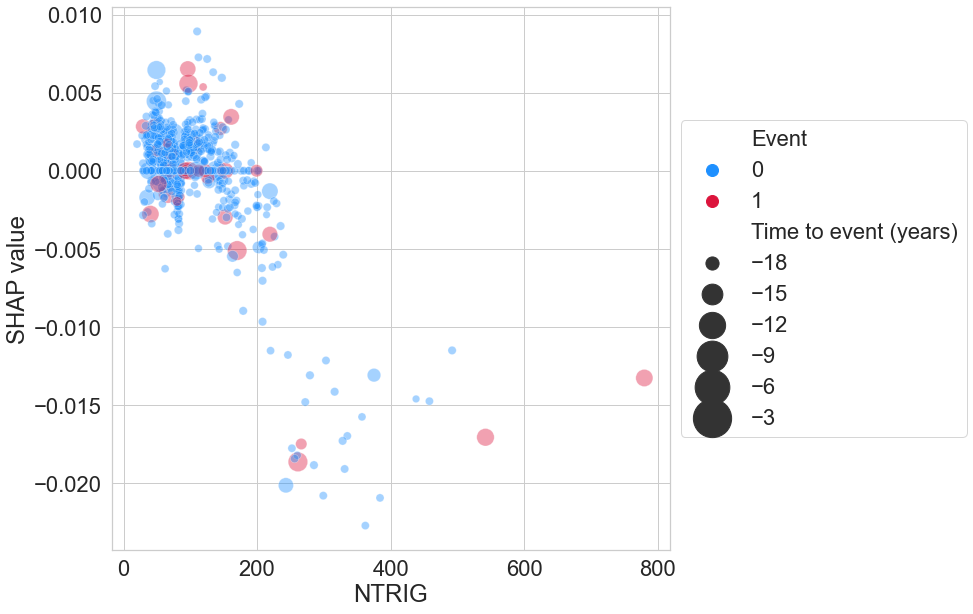

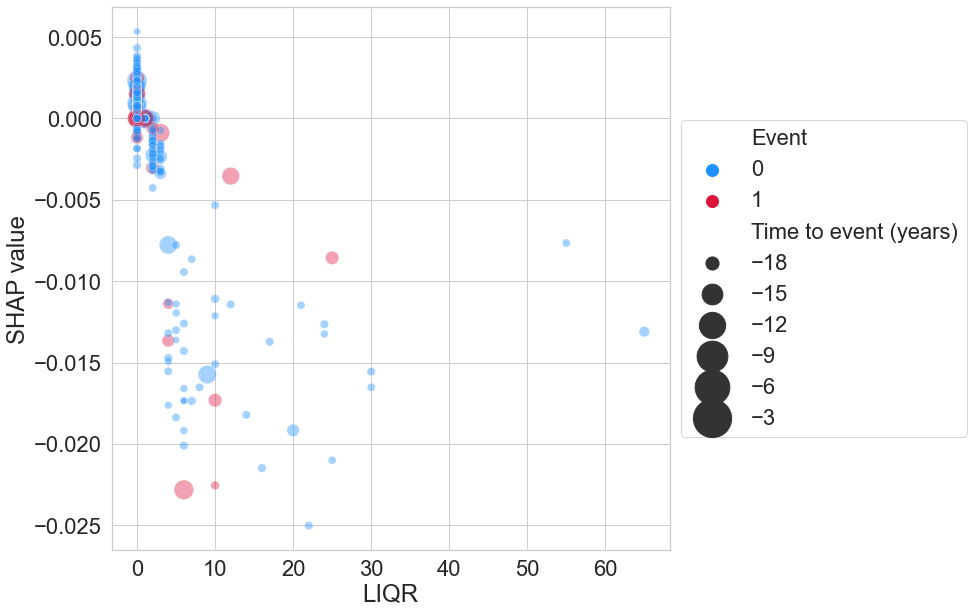

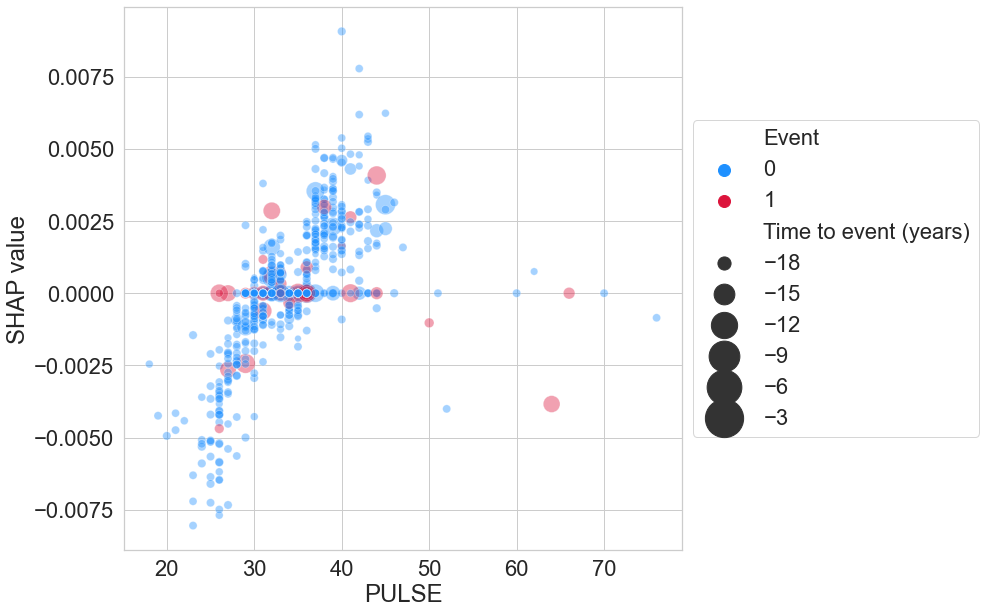

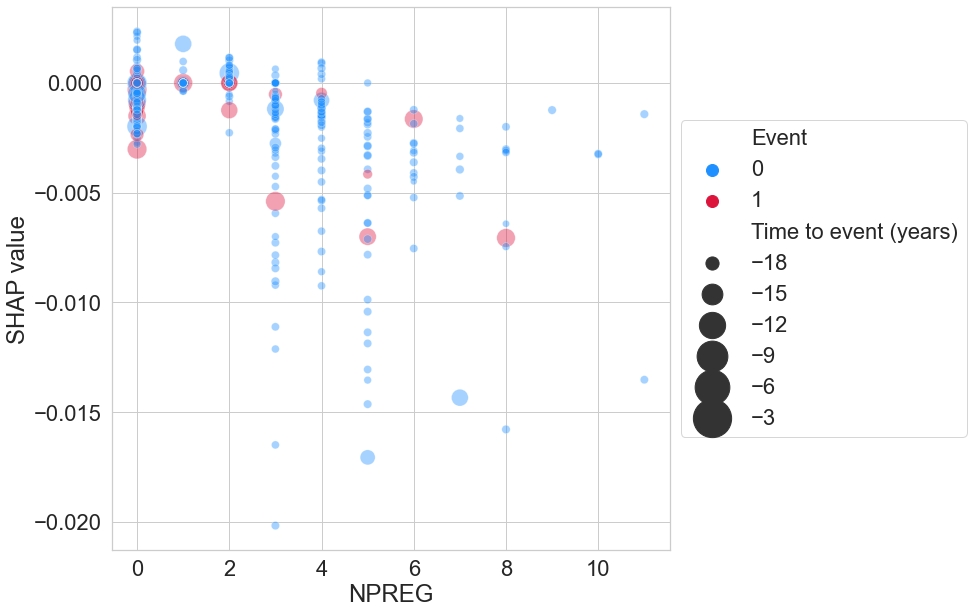

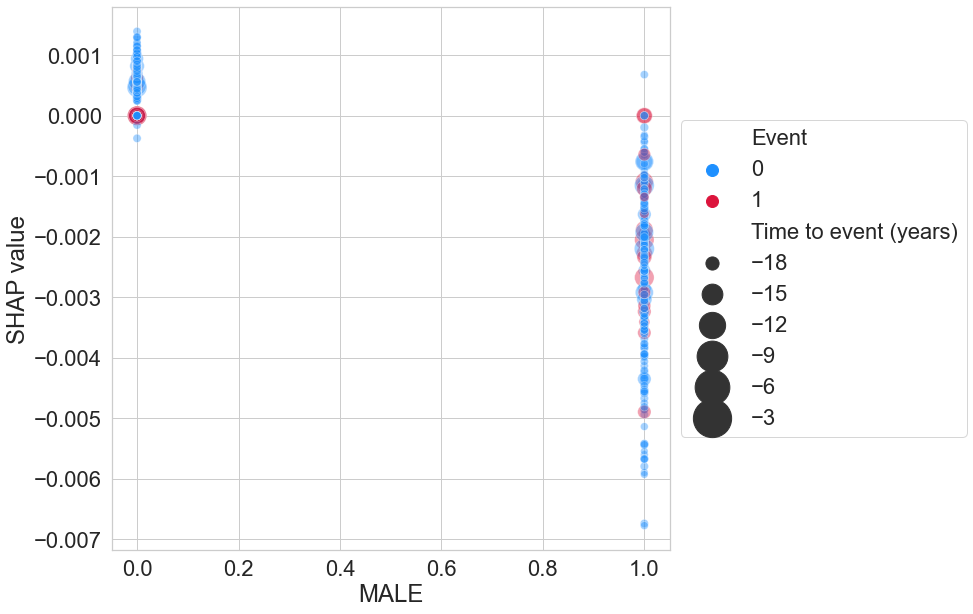

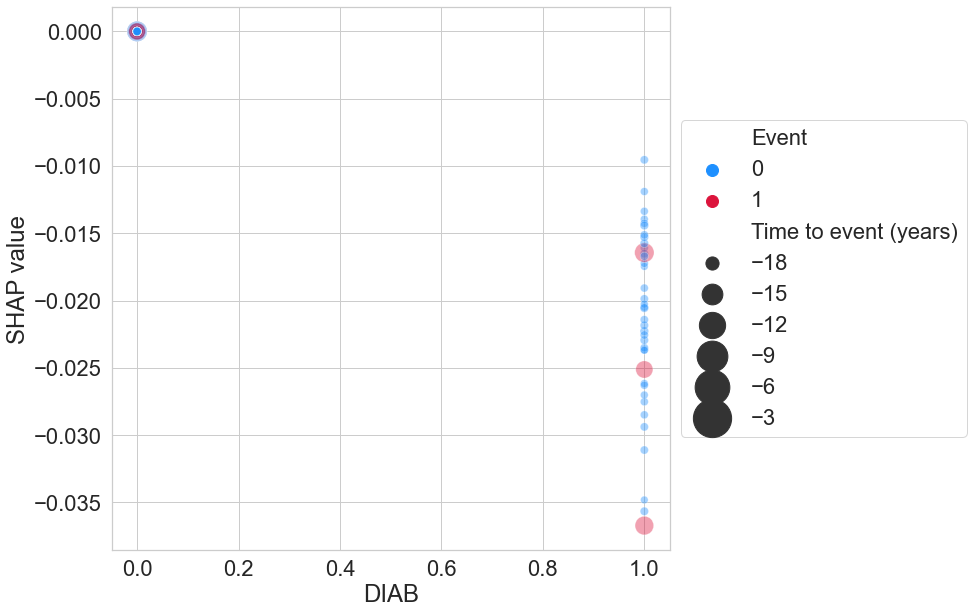

In [26]:
## Bubble Chart:

def plot_bubble_chart_SHAP(df, var):

    idx_oi = df.columns.get_loc(var)
    df_for_bc = pd.DataFrame({df.columns[idx_oi]:df.iloc[:, idx_oi]
                             , 'SHAP value': kmeans_shaps[:,idx_oi]
                             , 'event': test_df.event.values
                             , 'time': test_df.time.values})
    df_for_bc['Event'] = df_for_bc['event'].astype('category')

    df_for_bc['invert_time'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])


    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
    #sns.set()
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    bc_plot = sns.scatterplot(data=df_for_bc
                    , x=df.columns[idx_oi]
                    , y='SHAP value'
                    , size= 'Time to event (years)'
                    , hue='Event', palette = ['dodgerblue', 'crimson']
                    , alpha=0.4, sizes=(40, 400)
                    # , ax = ax
                    #, legend = False
                    # , label = str(Time_in_years) + ' years'
                    )
    plt.legend(loc = 'center left', markerscale = 2
               , bbox_to_anchor = (1, 0.5))

    plt.show()


top_n_var = 20
top_var_names_arr = vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    plot_bubble_chart_SHAP(featurespace_test_df, top_var_names_arr[i])
    

In [28]:
# !pip install xgboost

In [30]:
import shap
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl

X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

In [40]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:7.67904
[1000]	test-cox-nloglik:7.03034
[2000]	test-cox-nloglik:6.97615
[3000]	test-cox-nloglik:6.96378
[4000]	test-cox-nloglik:6.96498
[5000]	test-cox-nloglik:6.96896
[6000]	test-cox-nloglik:6.97368
[7000]	test-cox-nloglik:6.97740
[8000]	test-cox-nloglik:6.98025
[9000]	test-cox-nloglik:6.98389
[9999]	test-cox-nloglik:6.98790


In [41]:
params = {
    "eta": 0.002,
    "max_depth": 3, 
    "objective": "survival:cox",
    "subsample": 0.5
}
model_xgb = xgboost.train(params, xgb_full, 5000, evals = [(xgb_full, "test")], verbose_eval=1000)

[0]	test-cox-nloglik:9.28407
[1000]	test-cox-nloglik:8.60857
[2000]	test-cox-nloglik:8.53121
[3000]	test-cox-nloglik:8.49419
[4000]	test-cox-nloglik:8.47064
[4999]	test-cox-nloglik:8.45256


In [45]:
y_pred = model_train.predict(xgb_test, ntree_limit=5000)

In [47]:
np.min(y_pred) # predicted time to event?

0.043411978

In [43]:
shap_values_xgb = shap.TreeExplainer(model_xgb).shap_values(X)


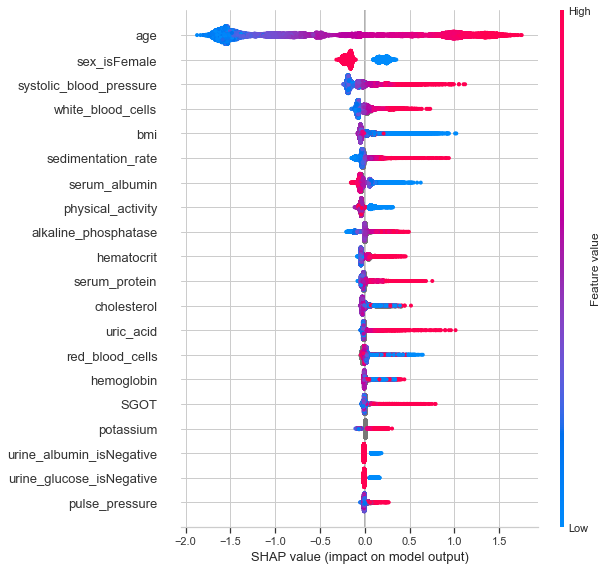

In [44]:
shap.summary_plot(shap_values_xgb, X)


## SHAP for Cox Y15 Models

In [52]:

##########################
# Build Cox model:

# Outerloop:
c_index = np.zeros((25,1))
# for fold in range(25):

## 
fold = 0
print('')
print('FOLD '+str(fold)+':')
print('')

# trainingid = trainingid_all.iloc[:,fold]
# trainingid = trainingid[~np.isnan(trainingid)]

trainingid = trainingid_all.iloc[:,fold].values
validationid = validationid_all.iloc[:,fold].values
testingid = testingid_all.iloc[:,fold].values

training_validation_id = np.concatenate([trainingid,validationid])
#training_validation_id = training_validation_id[~np.isnan(training_validation_id)]
#testingid = testingid[~np.isnan(testingid)]

#eligible_id = data_full['ID'][data_full['ID'].isin(training_validation_id)]
train_df = data_full.loc[data_full['ID'].isin(training_validation_id),:]
del train_df['ID']
test_df = data_full.loc[data_full['ID'].isin(testingid),:]
del test_df['ID']

featurespace_train_df = train_df.drop(['time','event'],axis =1)
featurespace_test_df = test_df.drop(['time','event'],axis =1)

featurespace_train = train_df.drop(['time','event'],axis =1).values
featurespace_test = test_df.drop(['time','event'],axis =1).values

y_train = sksurv.util.Surv.from_dataframe('event', 'time', train_df)
y_test = sksurv.util.Surv.from_dataframe('event', 'time', test_df)


seed(1)
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis

cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1, alpha_min_ratio=0.00001,  fit_baseline_model= True)
cox_lasso.fit(featurespace_train_df, y_train) 

savedir = os.path.join(work_dir,'csv_files/lasso_y15_SHAP/'+str(n_features)+'_features/')
try: 
    os.makedirs(savedir)
except OSError:
    if not os.path.isdir(savedir):
        raise
actual_fold = fold+1

cox_lasso.score(featurespace_test_df, y_test) 




FOLD 0:



0.7343284767160269

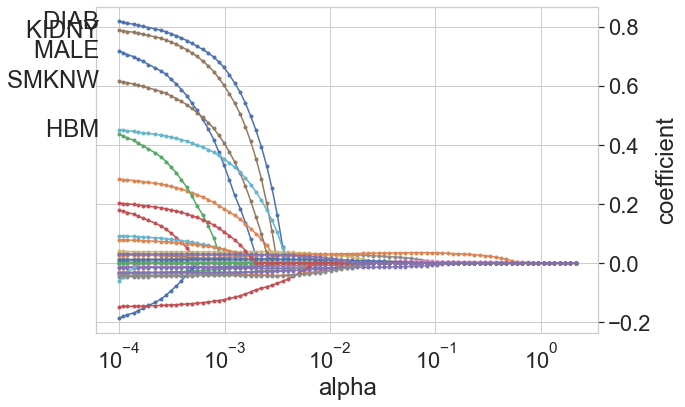

In [53]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=featurespace_train_df.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")
plot_coefficients(coefficients_lasso, n_highlight=5)



In [54]:
def f_lasso_input_as_matrix(X):
    surv = cox_lasso.predict_survival_function(X)
    last_yr_pred_prob_surv = np.empty(shape = X.shape[0])
    for subject_idx in range(X.shape[0]):
        last_yr_pred_prob_surv[subject_idx] = surv[subject_idx].y[-1]
    return last_yr_pred_prob_surv

In [56]:

## SHAP:
seed(1)
X_train_df_summary = shap.kmeans(featurespace_train_df, 7) #10

seed(1)
lasso_explainer_kmeans = shap.KernelExplainer(f_lasso_input_as_matrix, X_train_df_summary, feature_names=feature_name_list) 
lasso_kmeans_shaps = lasso_explainer_kmeans.shap_values(featurespace_test_df)


In [57]:
lasso_vimp_shap_kmeans = vimp_shap_tabular(feature_name_list, np.abs(lasso_kmeans_shaps).mean(0))
lasso_vimp_shap_kmeans.to_csv(savedir+'/shap_kernel_explainer_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

lasso_kmeans_shaps_df = pd.DataFrame(lasso_kmeans_shaps)
lasso_kmeans_shaps_df.columns = featurespace_test_df.columns
pd.DataFrame(lasso_kmeans_shaps_df).to_csv(savedir+'/all_kmeans_shap_values_df_expanded_var_2_fold_'+str(actual_fold)+'.csv', index = None, header = True)

lasso_explainer_kmeans.expected_value
# pd.DataFrame(explainer_kmeans.expected_value).to_csv(savedir+'/explainer_kmeans_expected_values_fold_'+str(actual_fold)+'.csv', index = None, header = True)
with open(savedir+'/explainer_kmeans_expected_values_2_fold_'+str(actual_fold)+'.txt', 'w') as f:
    f.write(str(lasso_explainer_kmeans.expected_value))


In [58]:
load_dir = 'U:/Hieu/CARDIA_longi_project/csv_files/lasso_y15_SHAP/all_features'
loaded_lasso_kmeans_shaps = pd.read_csv(load_dir+'/all_kmeans_shap_values_df_expanded_var_2_fold_1.csv')

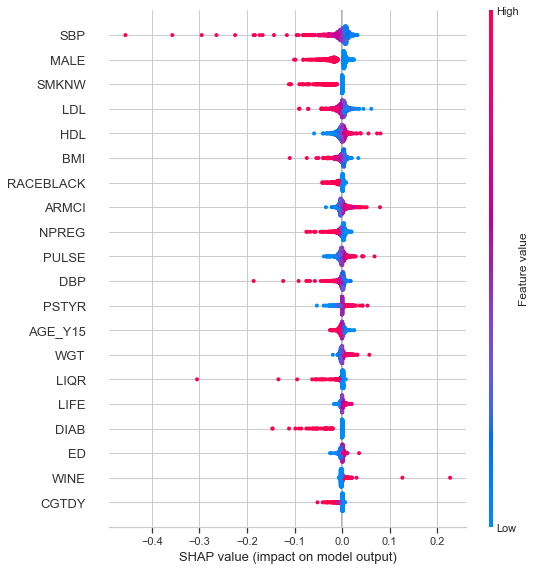

In [59]:
shap.initjs()
shap.summary_plot(loaded_lasso_kmeans_shaps.to_numpy(), featurespace_test_df)


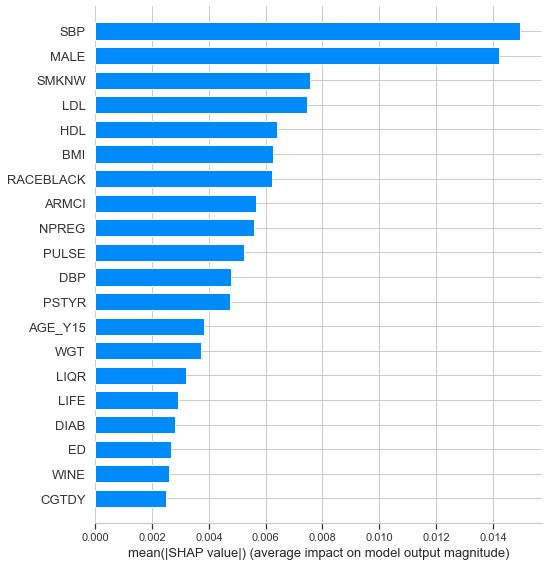

In [67]:
shap.summary_plot(loaded_lasso_kmeans_shaps, featurespace_test_df.iloc[:,:], plot_type = 'bar')


In [64]:
kmeans_shaps.shape

(711, 35)

In [65]:
loaded_lasso_kmeans_shaps.shape

(711, 35)

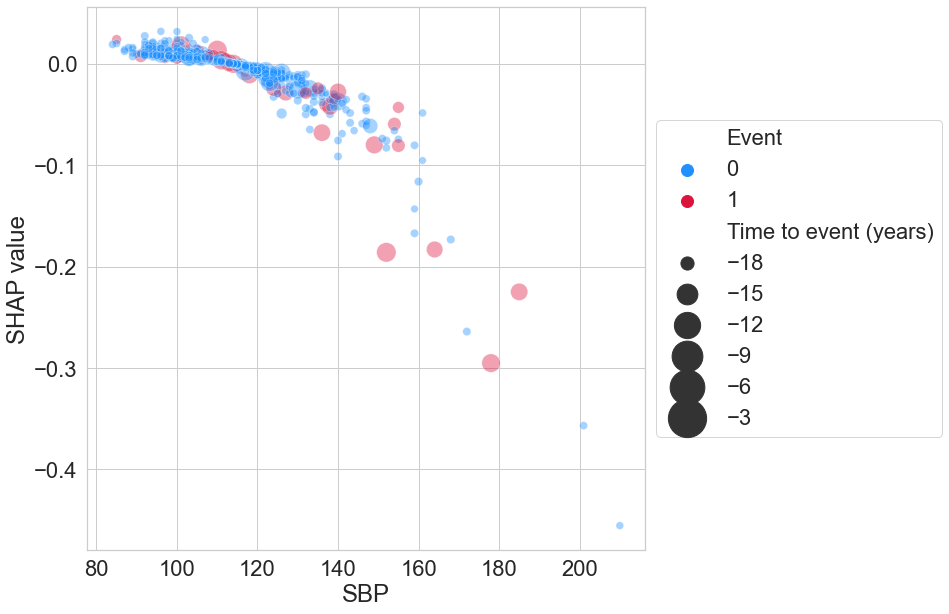

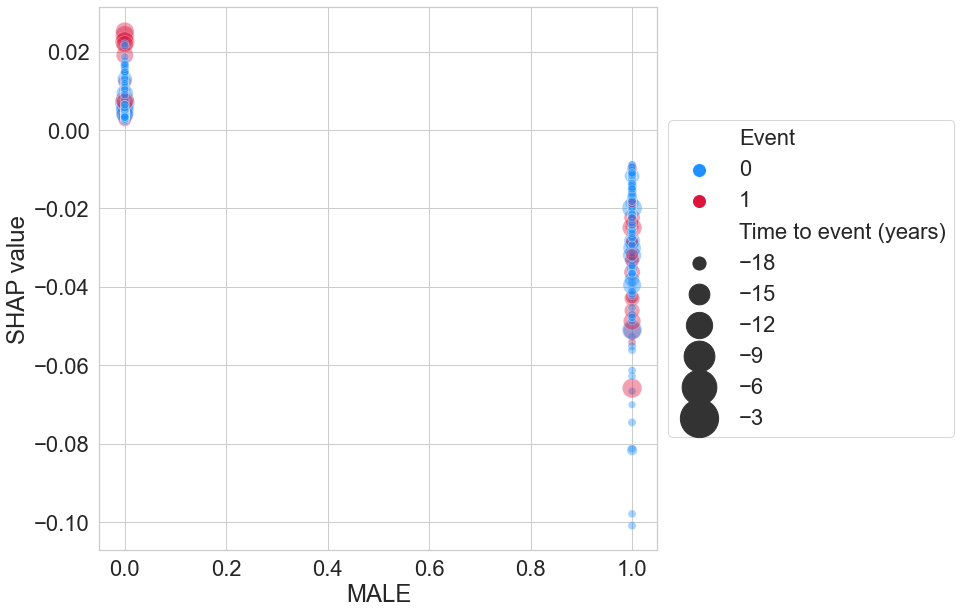

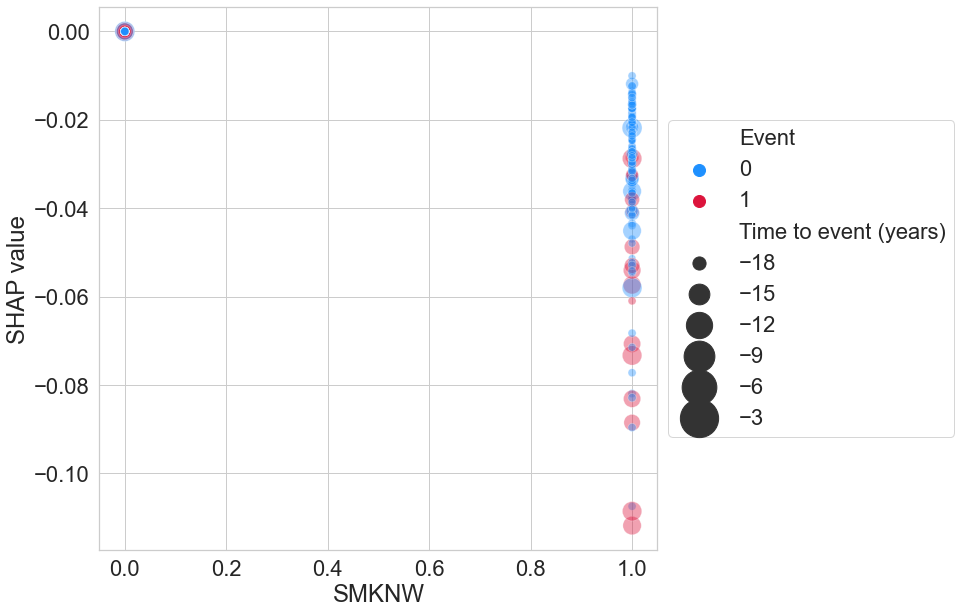

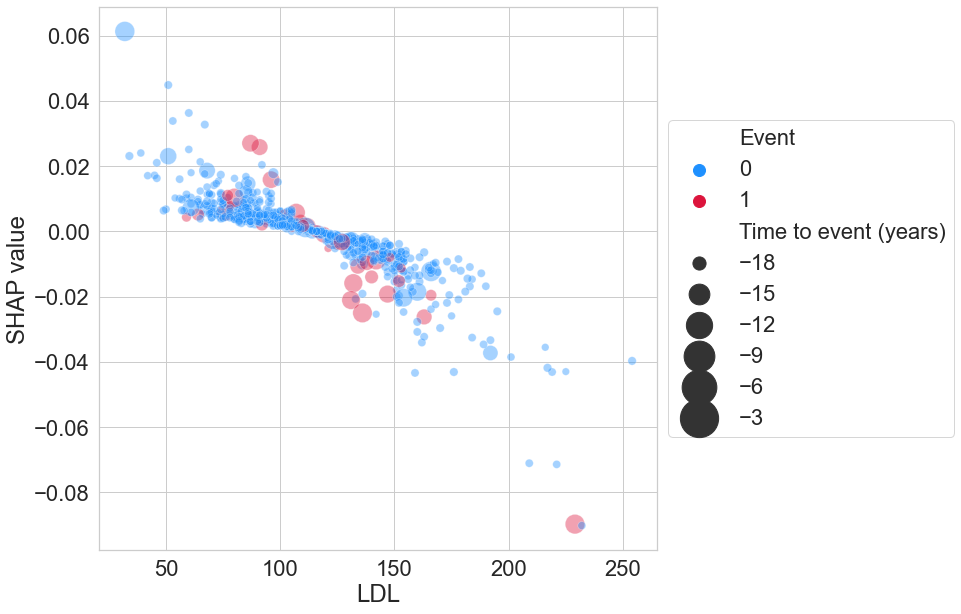

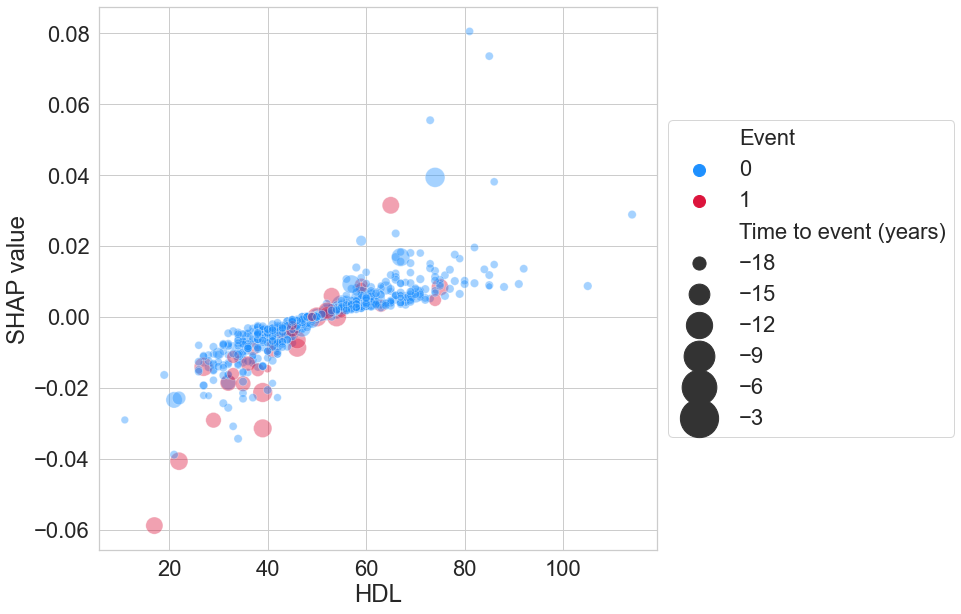

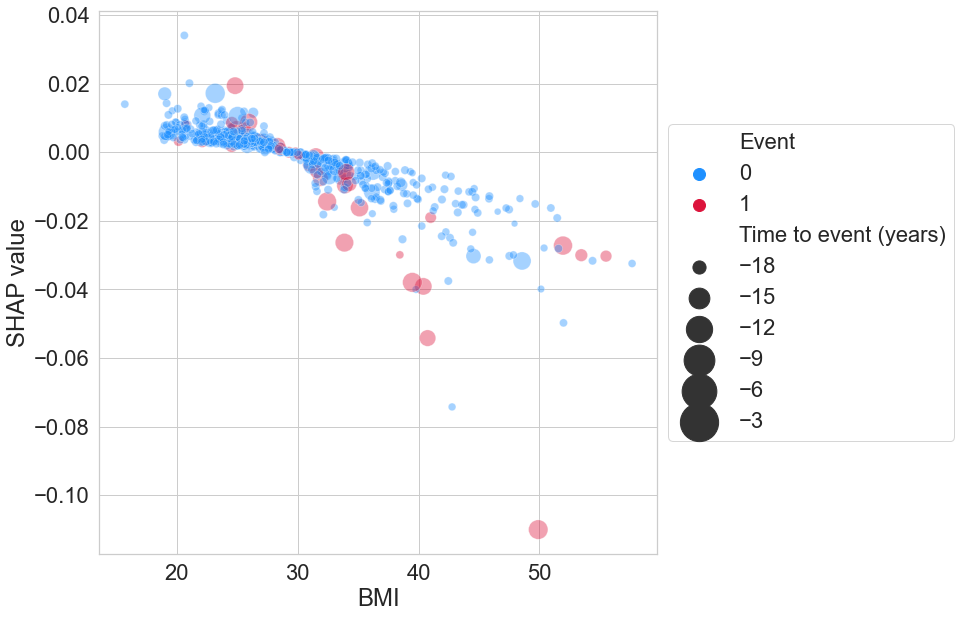

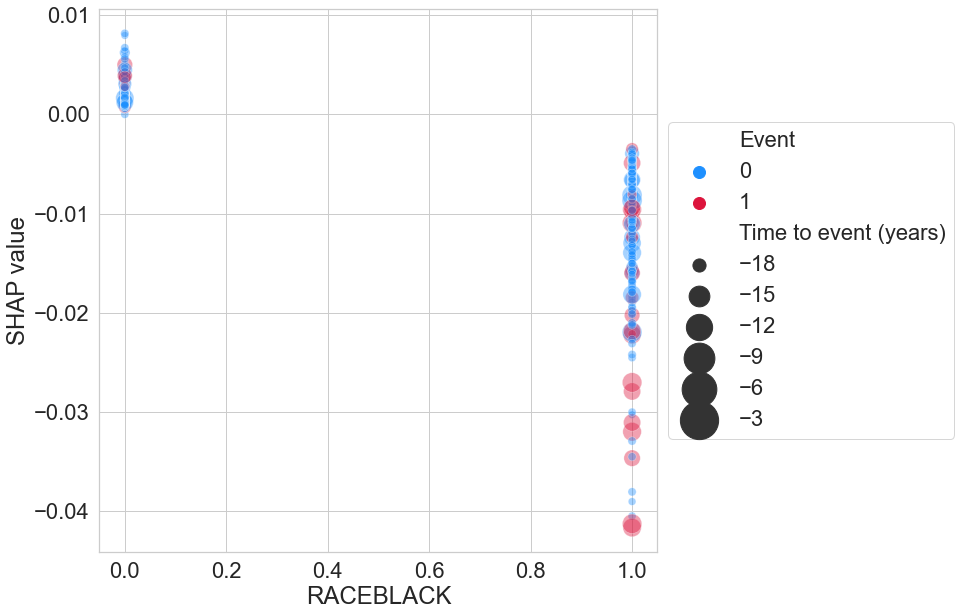

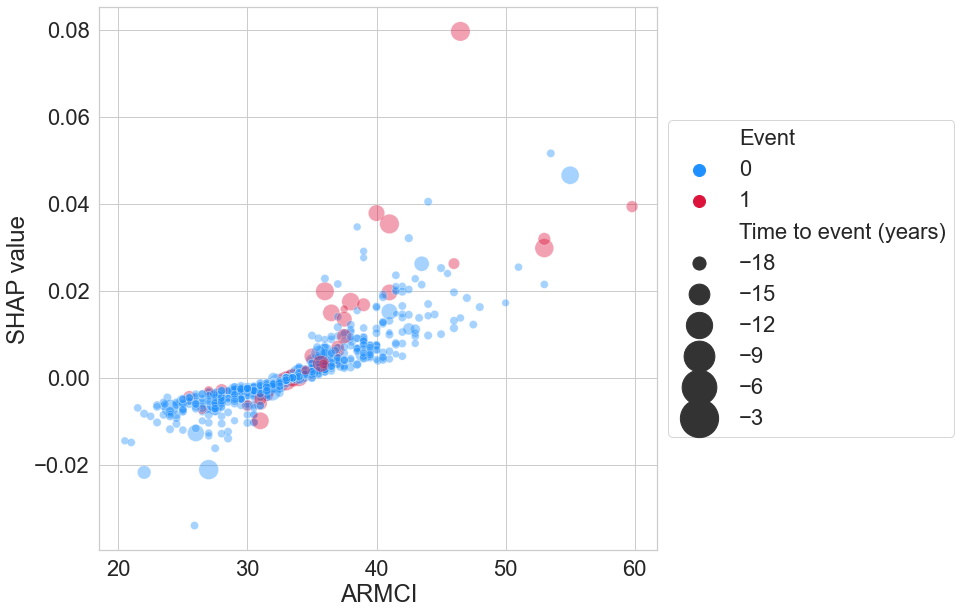

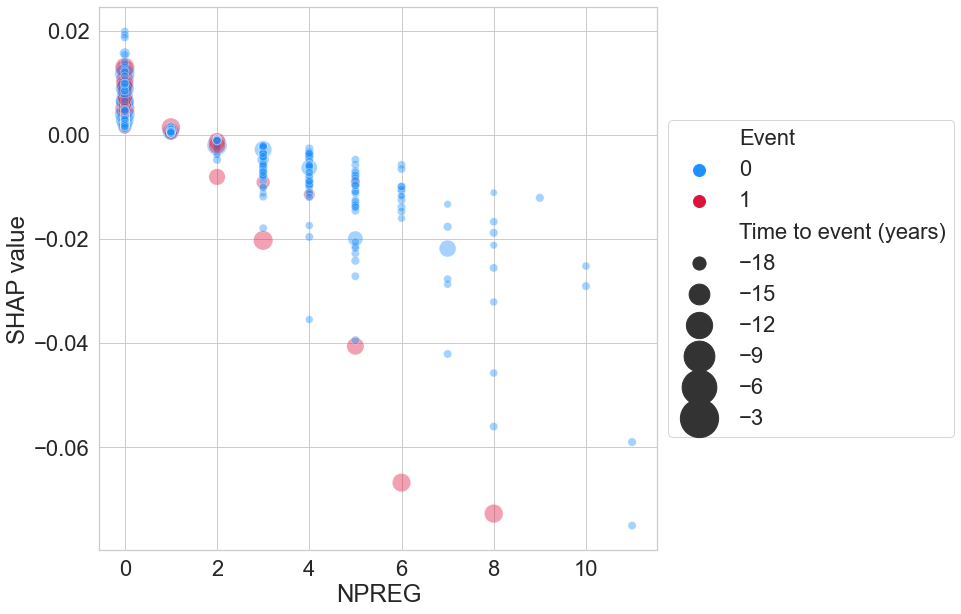

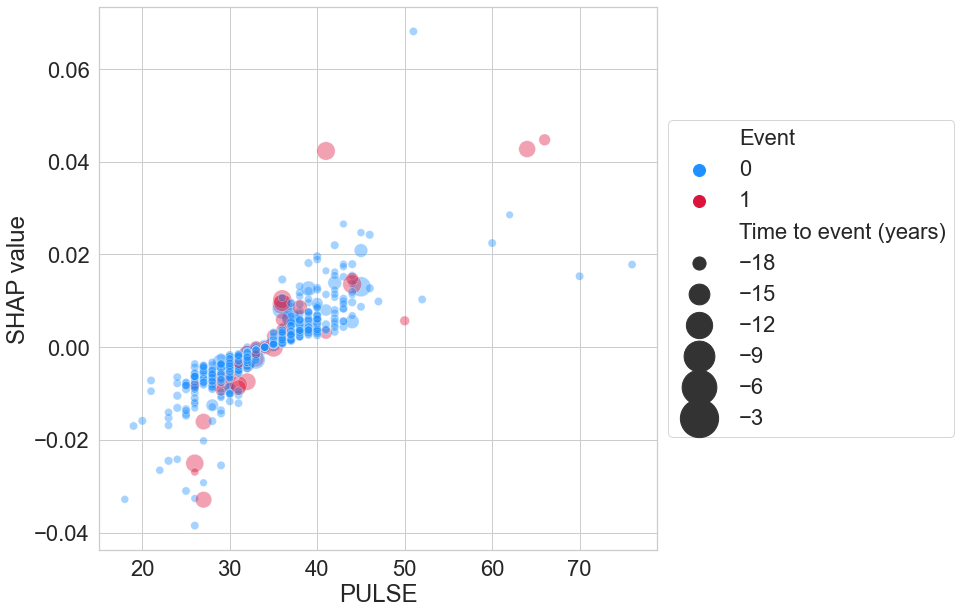

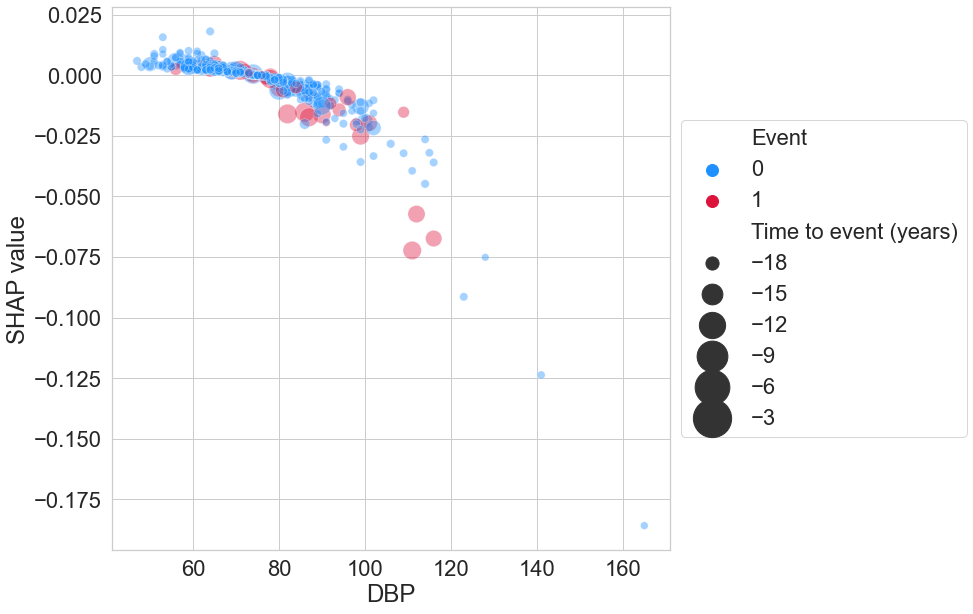

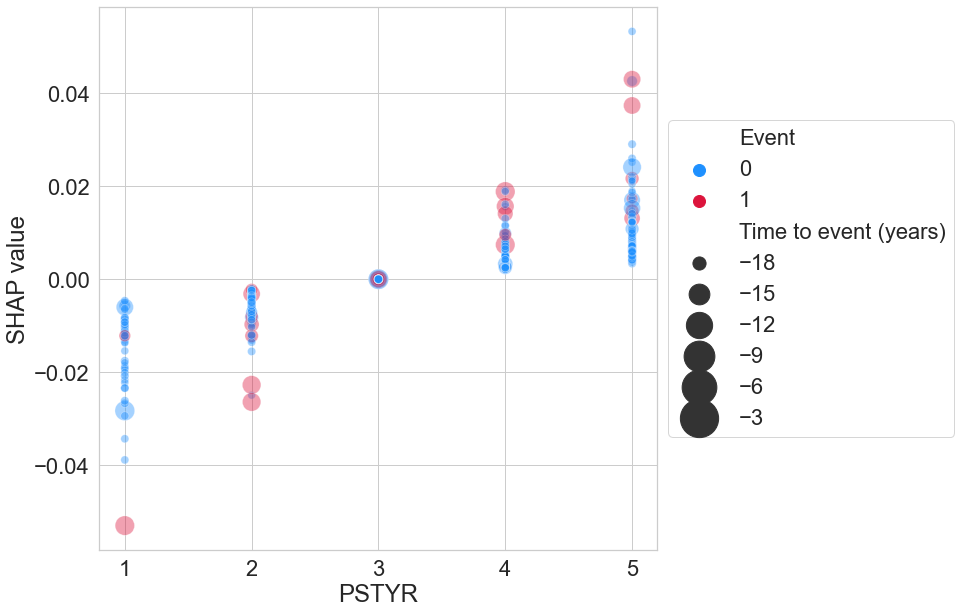

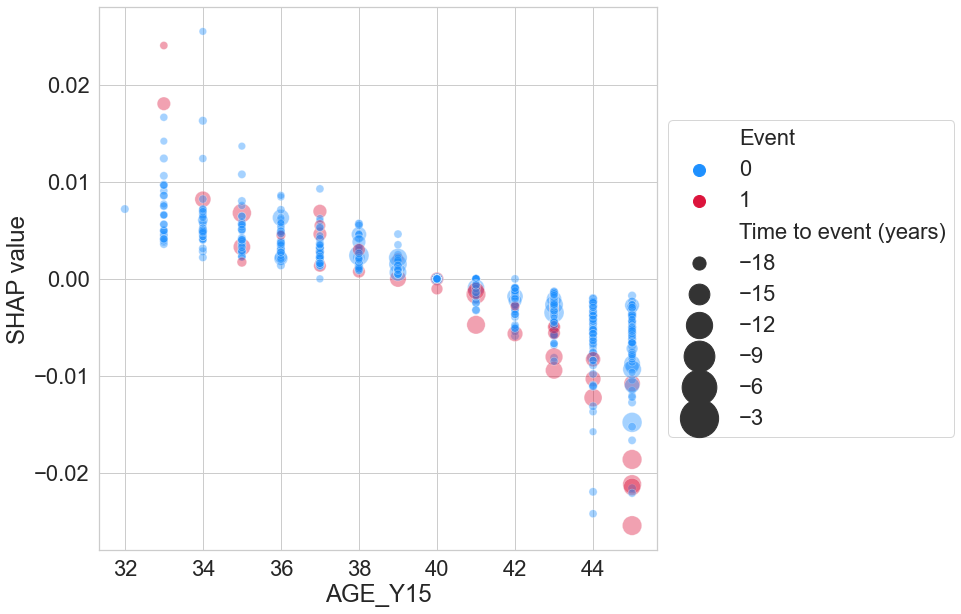

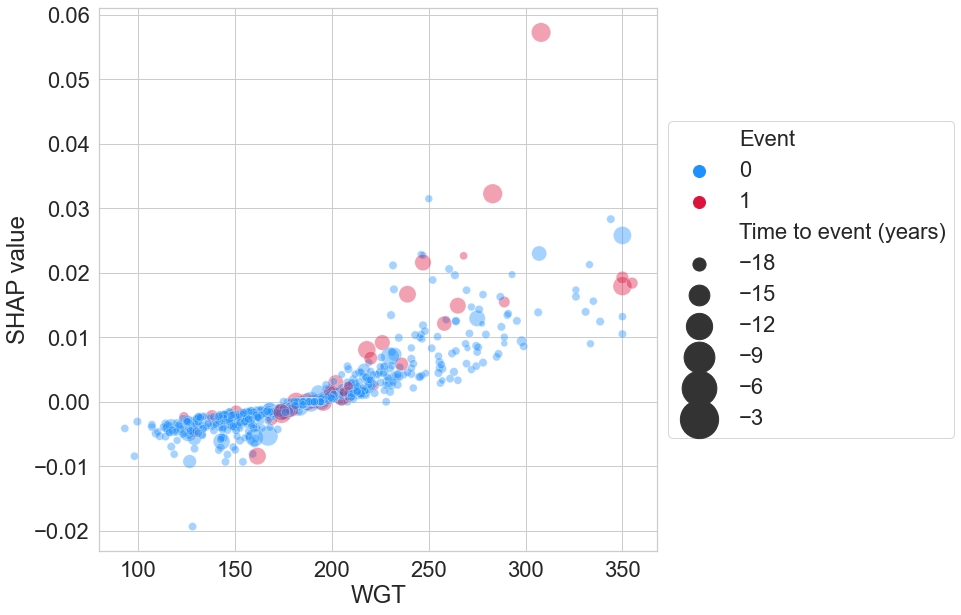

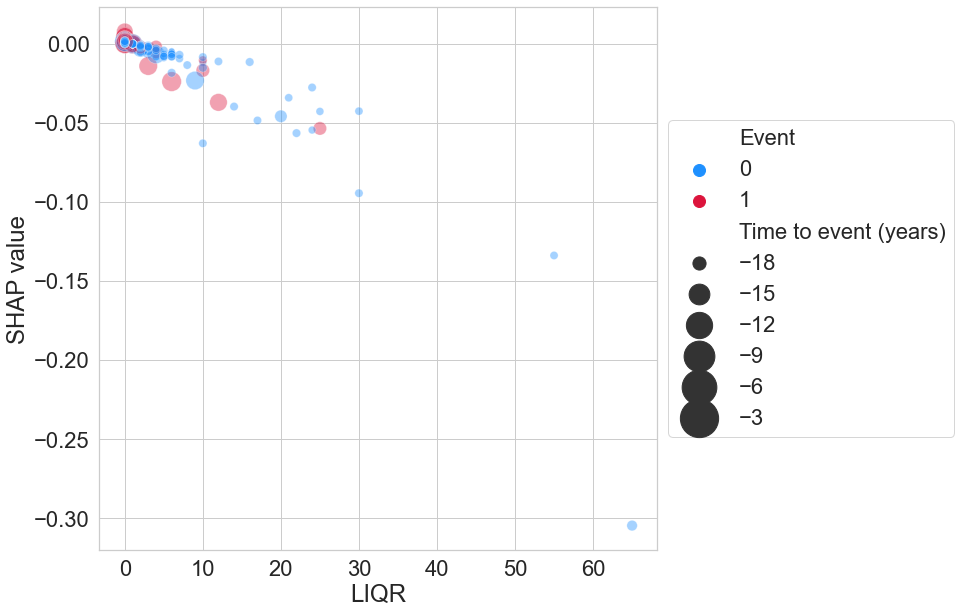

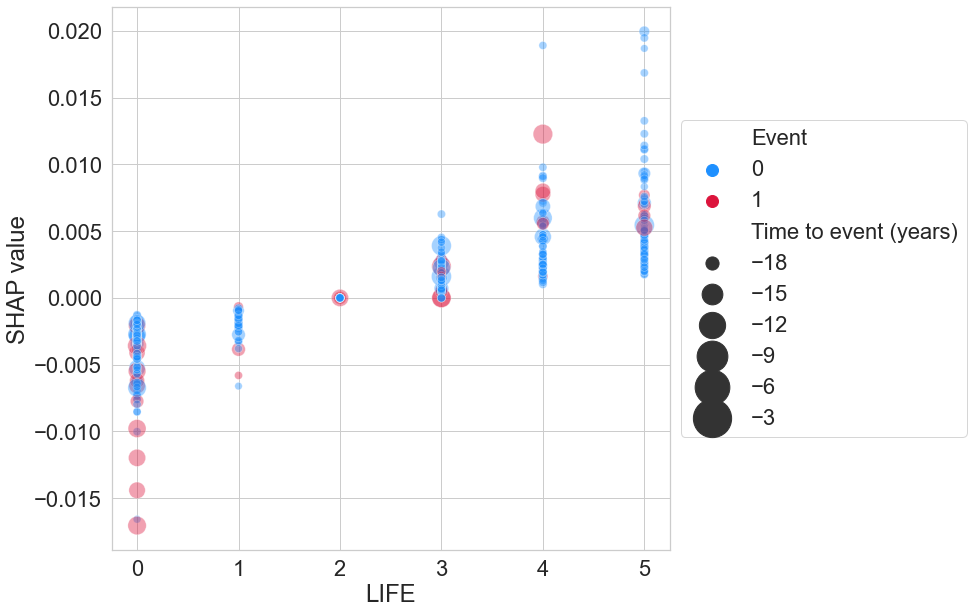

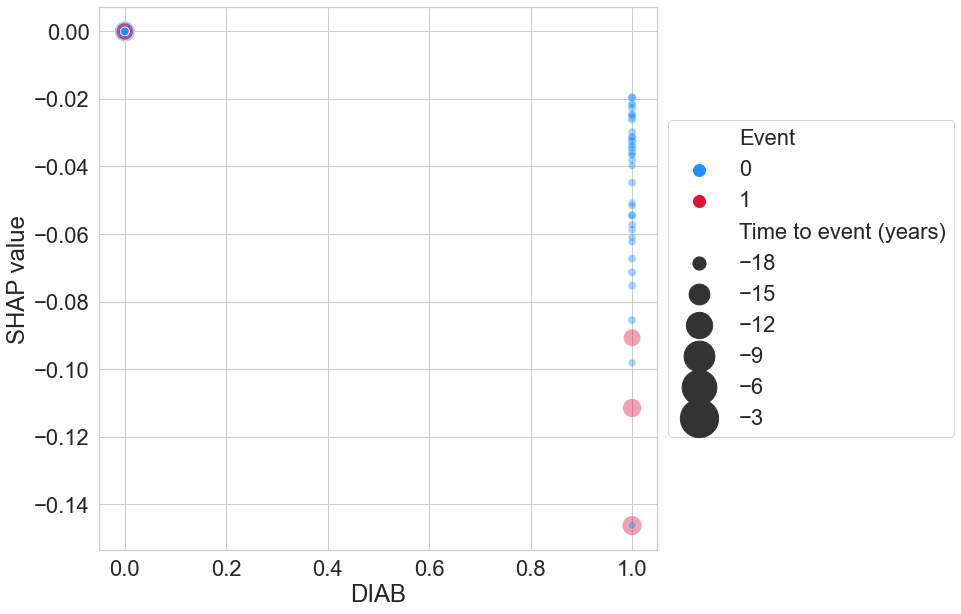

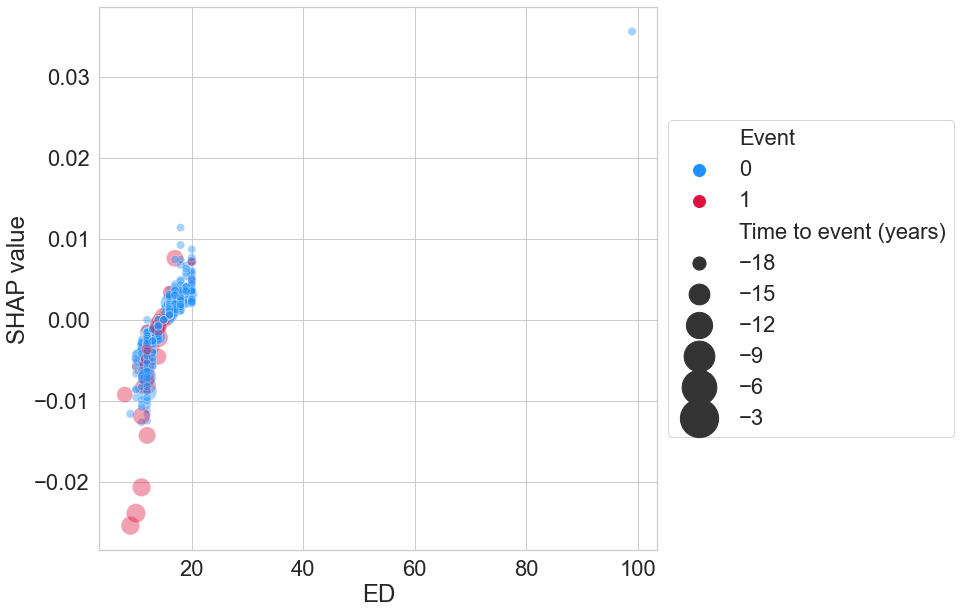

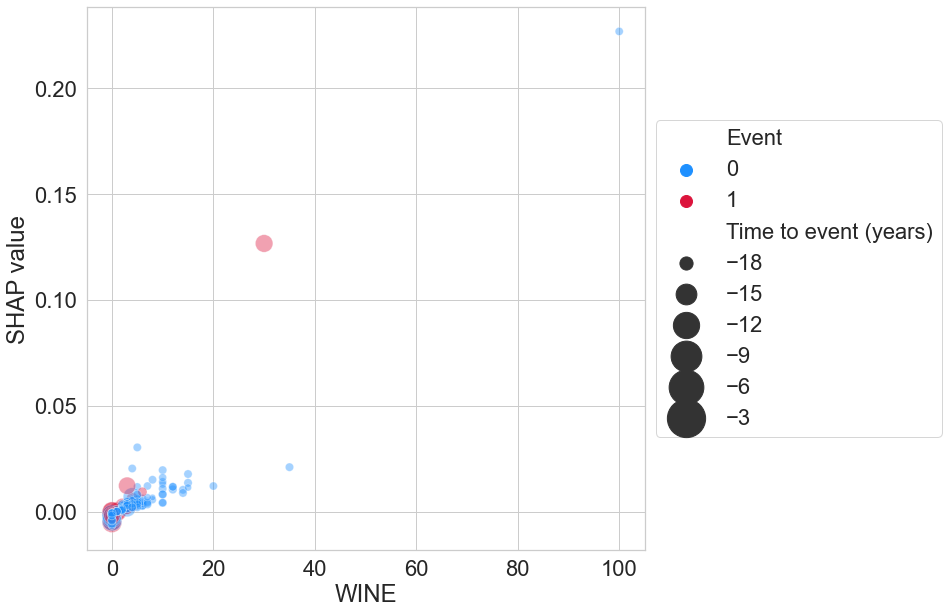

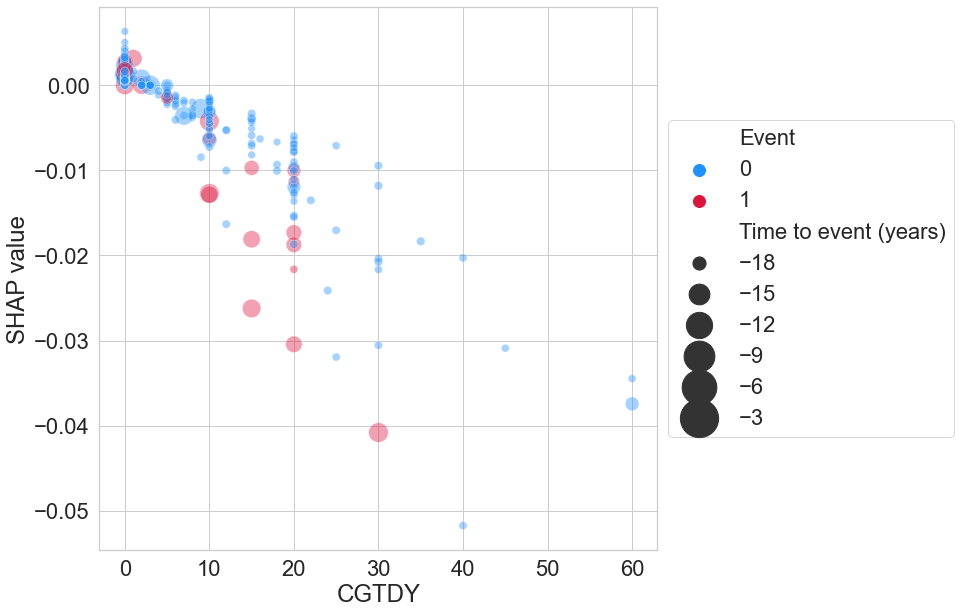

In [66]:
def plot_bubble_chart_SHAP(df, var, kmeans_shaps_=kmeans_shaps):

    idx_oi = df.columns.get_loc(var)
    df_for_bc = pd.DataFrame({df.columns[idx_oi]:df.iloc[:, idx_oi]
                             , 'SHAP value': kmeans_shaps_[:,idx_oi]
                             , 'event': test_df.event.values
                             , 'time': test_df.time.values})
    df_for_bc['Event'] = df_for_bc['event'].astype('category')

    df_for_bc['invert_time'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])
    df_for_bc['Time to event (years)'] = -(df_for_bc['time'])


    import seaborn as sns
    sns.set(rc={'figure.figsize':(10,10)}, font_scale = 2, style = 'whitegrid')
    #sns.set()
    #fig, ax = plt.subplots(figsize=(10, 10))
    
    bc_plot = sns.scatterplot(data=df_for_bc
                    , x=df.columns[idx_oi]
                    , y='SHAP value'
                    , size= 'Time to event (years)'
                    , hue='Event', palette = ['dodgerblue', 'crimson']
                    , alpha=0.4, sizes=(40, 400)
                    # , ax = ax
                    #, legend = False
                    # , label = str(Time_in_years) + ' years'
                    )
    plt.legend(loc = 'center left', markerscale = 2
               , bbox_to_anchor = (1, 0.5))

    plt.show()

    
    
top_n_var = 20
top_var_names_arr = lasso_vimp_shap_kmeans.variable_name[:top_n_var].values
for i in range(top_n_var):
    plot_bubble_chart_SHAP(featurespace_test_df, top_var_names_arr[i], loaded_lasso_kmeans_shaps.to_numpy())
    